## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'ravdess-1e5rawcomp' #dataset-compression
TRANSFORM = 'fft-male' #transform-group
CHANNEL = ''

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
male_fft_1e5rawcomp_ravdess.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawcomp\\fft\\male'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
#group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data","raw-transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
group_data_map.keys()
group_total_samples = {}
for i in group_data_map:
    group_total_samples[i] = len(group_data_map[i])

In [7]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // 10, 1)]

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map

Running 12760 CDFs


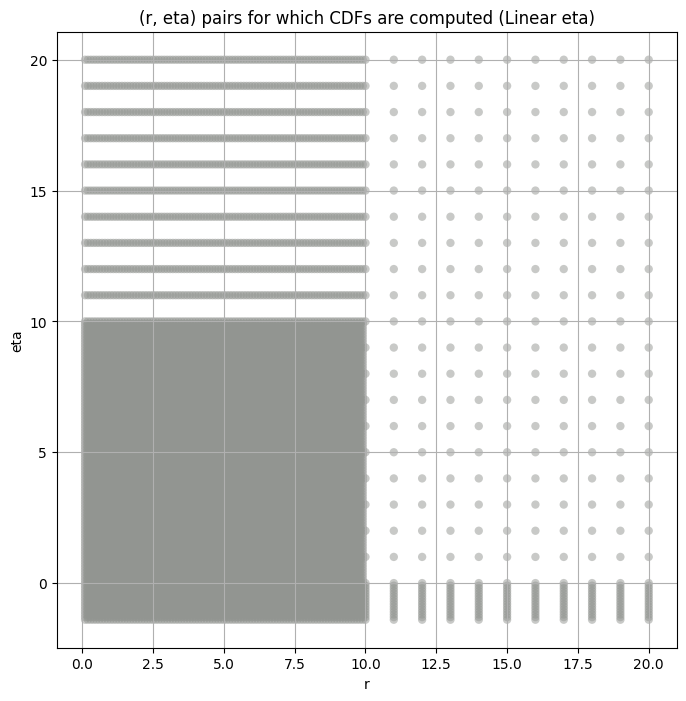

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [8]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [9]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [10]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 11


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 14


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 17


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 20


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 23


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 26


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 29


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,3.907990e+14,3.213011e+14,4.705622e+14,5.981112,3.060706,8.597465,1440.0
5,8.619868e+14,7.597638e+14,9.705736e+14,20.513369,17.319409,23.942896,14400.0
8,1.826341e+14,1.574274e+14,2.108616e+14,30.720031,21.959829,41.223043,27360.0
11,1.413384e+13,1.141042e+13,1.895579e+13,105.616169,12.570871,283.376403,56160.0
14,3.339637e+14,3.084108e+14,3.620677e+14,7.901885,5.022119,12.454595,100000.0
17,4.391542e+14,4.184581e+14,4.612009e+14,1.599081,1.112939,2.882672,100000.0
20,1.863235e+13,1.759787e+13,1.997386e+13,3.611286,1.579866,15.278751,100000.0
23,5.684017e+12,5.313017e+12,6.385912e+12,9.221800,2.312359,81.392754,100000.0
26,2.836541e+11,2.676022e+11,3.008791e+11,3.267833,2.205742,6.772957,100000.0


## Initial Grid Search and Hypothesis Test Plots

In [11]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [12]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,3.907990e+14,3.907990e+14,2.319760e+14,1.849258e+14,1.540045e+14,1.309170e+14,9.756222e+13,7.362395e+13,5.589937e+13,4.172995e+13,3.079363e+13,1.049233e+13
5,8.619868e+14,8.619868e+14,6.858902e+14,5.850014e+14,5.133091e+14,4.604947e+14,3.807375e+14,3.243172e+14,2.824609e+14,2.499133e+14,2.242417e+14,1.716472e+14
8,1.826341e+14,1.826341e+14,1.499980e+14,1.328254e+14,1.214495e+14,1.123461e+14,9.796725e+13,8.710518e+13,7.858027e+13,7.192226e+13,6.644412e+13,5.504683e+13
11,1.413384e+13,1.413384e+13,1.111406e+13,1.053647e+13,1.016795e+13,9.899331e+12,9.485270e+12,9.153794e+12,8.885967e+12,8.657039e+12,8.459356e+12,7.981436e+12
14,3.339637e+14,3.339637e+14,3.258439e+14,3.210852e+14,3.171588e+14,3.136968e+14,3.076059e+14,3.023106e+14,2.975012e+14,2.931221e+14,2.890553e+14,2.780791e+14
17,4.391542e+14,4.391542e+14,4.337970e+14,4.298841e+14,4.264108e+14,4.232242e+14,4.174343e+14,4.121971e+14,4.073428e+14,4.027867e+14,3.984890e+14,3.867818e+14
20,1.863235e+13,1.863235e+13,1.827303e+13,1.806922e+13,1.789298e+13,1.773310e+13,1.744662e+13,1.719097e+13,1.695731e+13,1.674032e+13,1.653722e+13,1.599138e+13
23,5.684017e+12,5.684017e+12,5.526452e+12,5.449588e+12,5.384495e+12,5.326447e+12,5.224058e+12,5.134148e+12,5.053071e+12,4.978669e+12,4.909644e+12,4.726615e+12
26,2.836541e+11,2.836541e+11,2.786519e+11,2.752278e+11,2.722437e+11,2.695398e+11,2.646953e+11,2.603807e+11,2.564422e+11,2.527944e+11,2.493840e+11,2.402279e+11


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.15348214205873856 390799019528792.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.15692869200886417 231975987365711.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.17489049662700606 184925845292006.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.19290048969572737 154004478557263.47


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.20964537910268566 130916957148344.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.24150558756468554 97562222573528.02


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.27331337109542864 73623947338130.28


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.3047609799326563 55899373441689.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.3373324180719659 41729953474020.625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.3687405770718623 30793627708387.918


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.45625414310456774 10492334403612.355
Number of samples: 1440, Without approximation : 1440.0


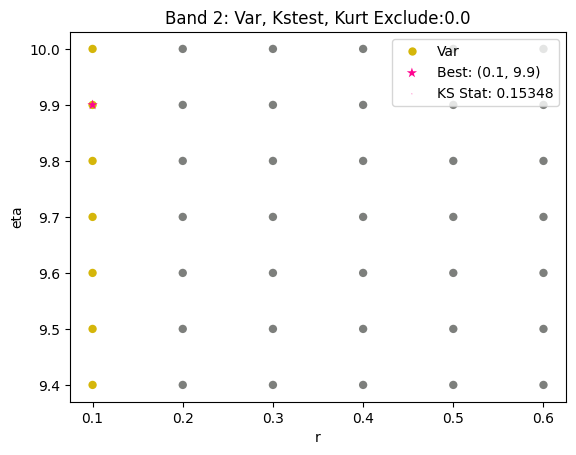

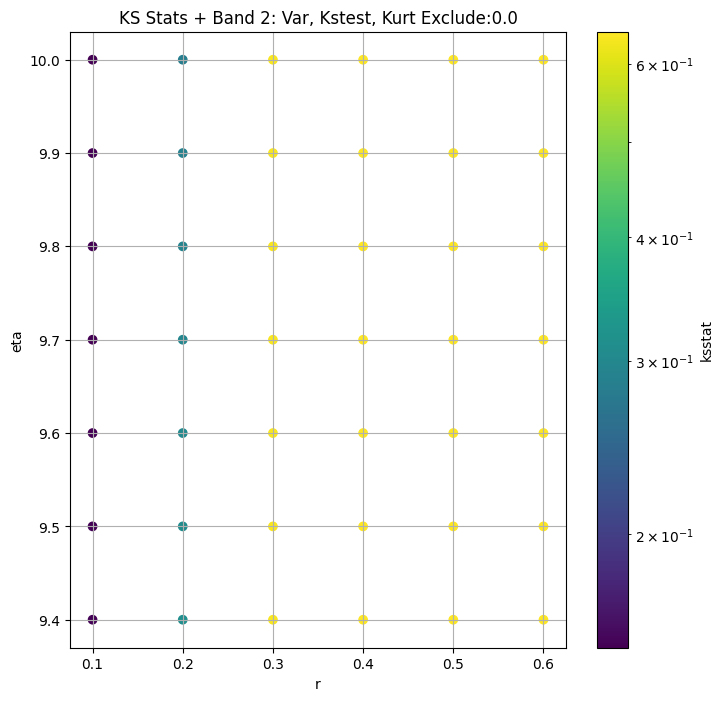

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.0341841571370925 861986803825730.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.03040177549493084 685890233184127.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.02748384543263449 585001423018844.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0250144052816096 513309126587763.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.0228789552459 460494673480690.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.021245275887009973 380737460576580.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.020931029322034278 324317231619331.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.02335830897890212 282460943583035.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.02594241782023221 249913289487294.38


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.029086538781227356 224241683726767.34


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.0388265693475599 171647225998272.12
Number of samples: 14400, Without approximation : 14400.0


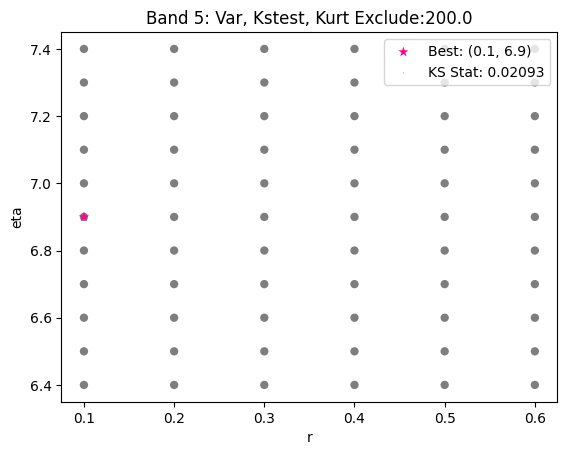

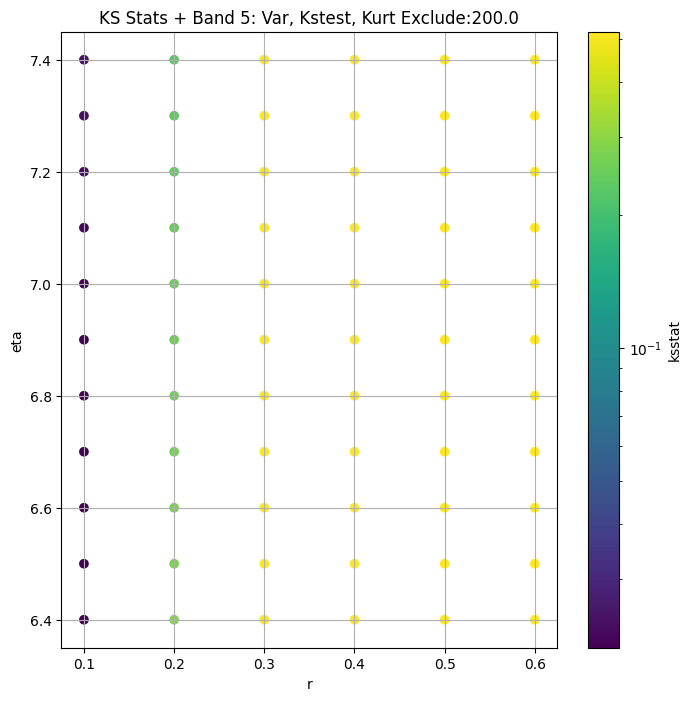

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.023238996180580566 182634081170201.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.023238996180580566 149998027565954.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.023238996180580566 132825406916152.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.023238996180580566 121449489692504.19


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.023238996180580566 112346085156144.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0216649023944252 97967250132434.4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.019489101707631296 87105180768094.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.017838488007540065 78580268850338.05


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.017674195245220847 71922259724579.78


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.017826509049779234 66444117468162.836


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.022843223442520696 55046830936915.83
Number of samples: 27360, Without approximation : 27360.0


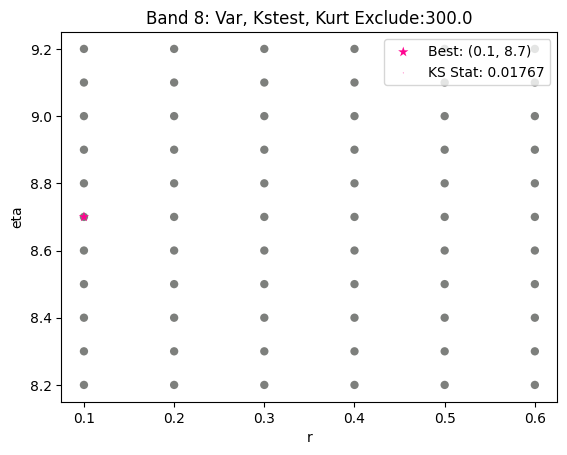

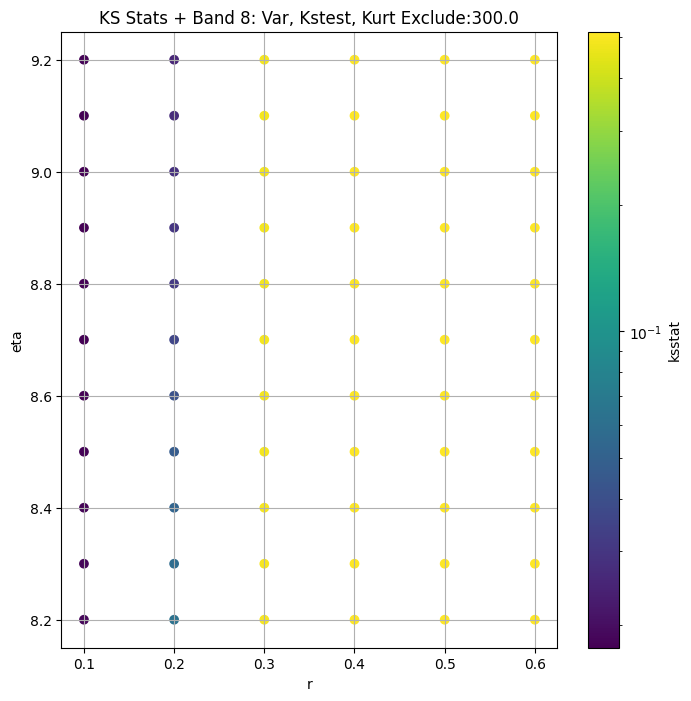

####
Band  11


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 0 0.008188616990843611 14133839770939.35


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 25 0.008188616990843611 11114058025352.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 50 0.007388009038966303 10536470092058.898


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 75 0.006129184613777566 10167952680545.52


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 100 0.005028314821866803 9899330680480.291


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 150 0.004340069467471341 9485269804228.3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 200 0.005059992965684823 9153794424162.377


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 250 0.005928262237128501 8885967046512.611


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 300 0.006614131235746501 8657038904504.086


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 350 0.007620075426386208 8459356221937.887


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
11 500 0.011560918889270688 7981435947324.612
Number of samples: 56160, Without approximation : 56160.0


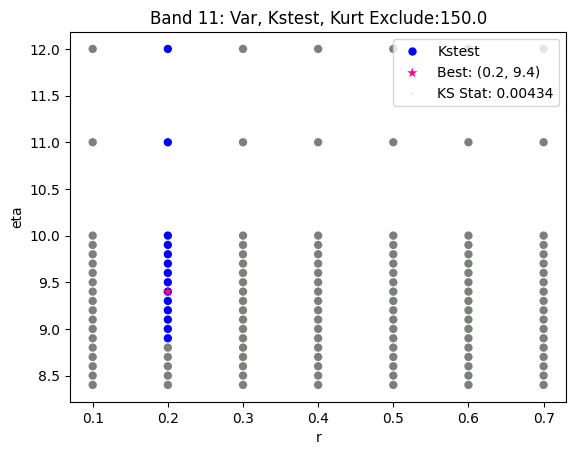

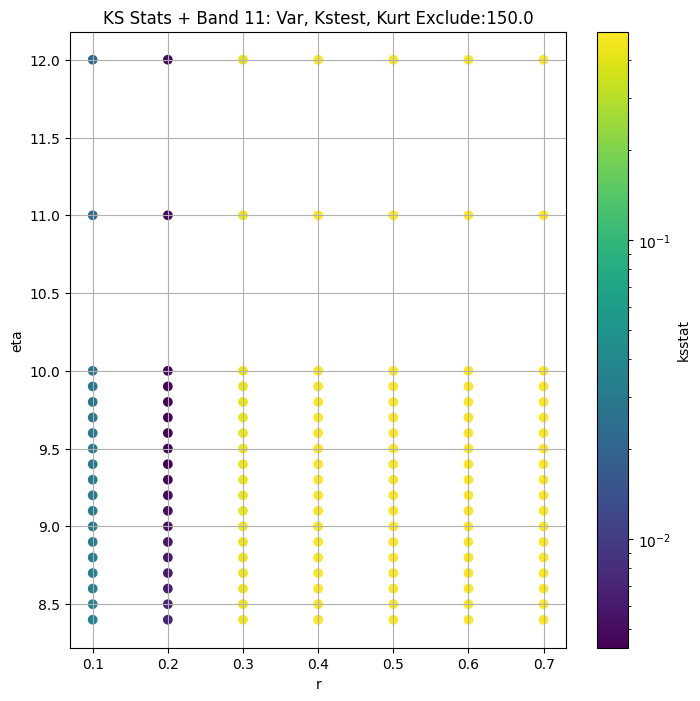

####
Band  14


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 0 0.06851888303858622 333963696397857.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 25 0.06796390921703327 325843945987703.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 50 0.06774889089286174 321085241500707.8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 75 0.06787569400656548 317158793601955.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 100 0.0681360118763212 313696783546832.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 150 0.06853190806128695 307605878001531.25


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 200 0.06880154355202259 302310588508915.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 250 0.06913050813561494 297501242653302.9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 300 0.06950668645951386 293122129517668.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 350 0.06986903977353376 289055304462797.06


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
14 500 0.0704339340535659 278079117130983.12
Number of samples: 100000, Without approximation : 100000.0


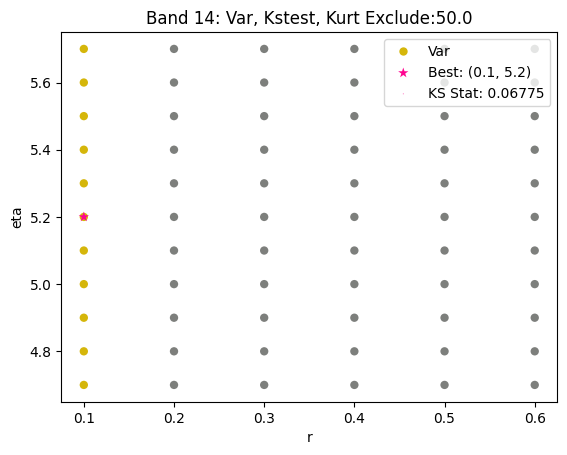

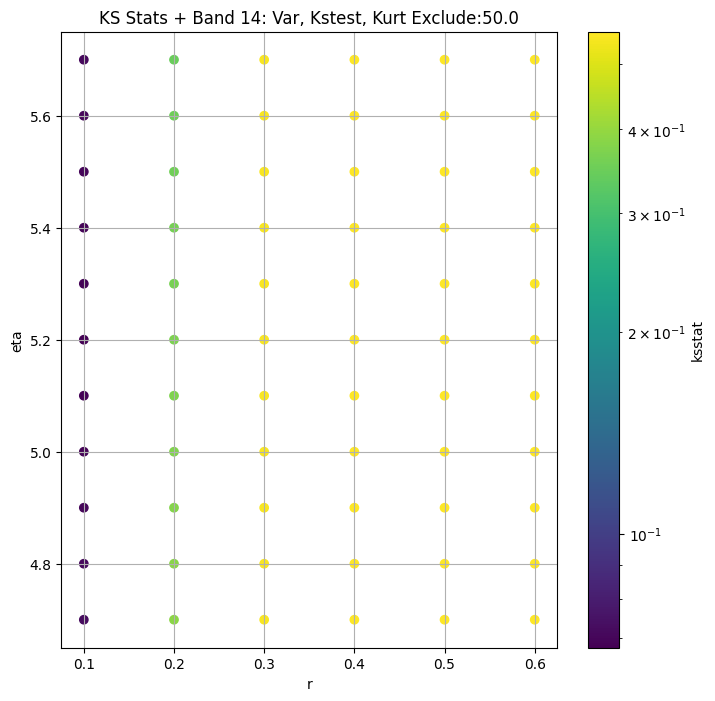

####
Band  17


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 0 0.006790265715169108 439154200765636.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 25 0.008053306232883195 433796998308295.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 50 0.008984344696977675 429884128734079.56


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 75 0.00981689417675835 426410848029660.2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 100 0.010585852920357713 423224175872057.6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 150 0.011995667207374633 417434253961199.5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 200 0.012114361468847368 412197058122223.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 250 0.011137654991434043 407342845368837.44


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 300 0.01025789267918975 402786741353033.75


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 350 0.009453665892464769 398489040988204.7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
17 500 0.010426435496461106 386781831369343.5
Number of samples: 100000, Without approximation : 100000.0


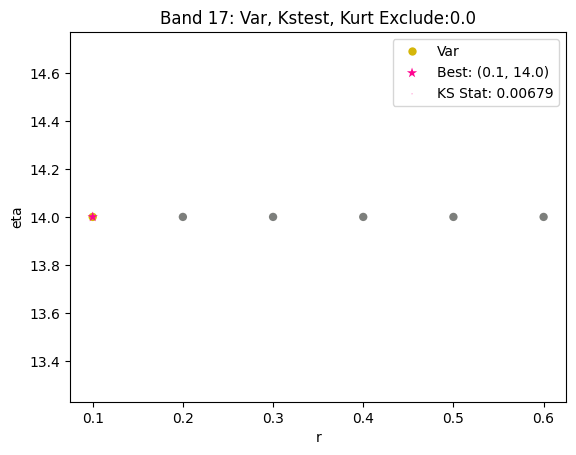

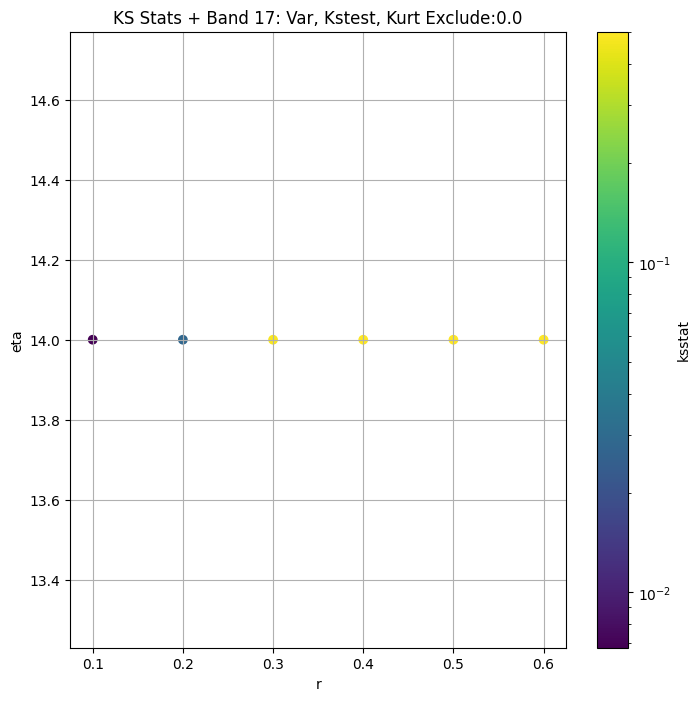

####
Band  20


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 0 0.0022730235850942915 18632354905639.773


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 25 0.0018197781169690327 18273028688962.547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 50 0.0021493389279683695 18069217417831.375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 75 0.002594822966891952 17892983581297.12


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 100 0.0030263488679326336 17733097500663.0


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 150 0.0039033044849425477 17446619304004.135


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 200 0.004719136233721513 17190966847618.346


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 250 0.00548975996515115 16957306083040.764


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 300 0.006241452919568999 16740323813696.85


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 350 0.006953211181155786 16537222010263.584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
20 500 0.008989125473072297 15991379823806.078
Number of samples: 100000, Without approximation : 100000.0


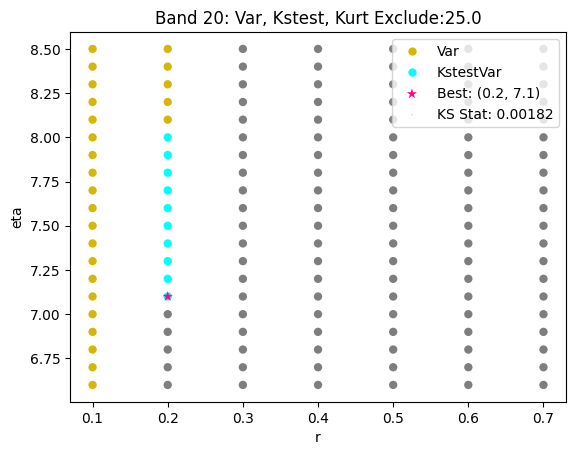

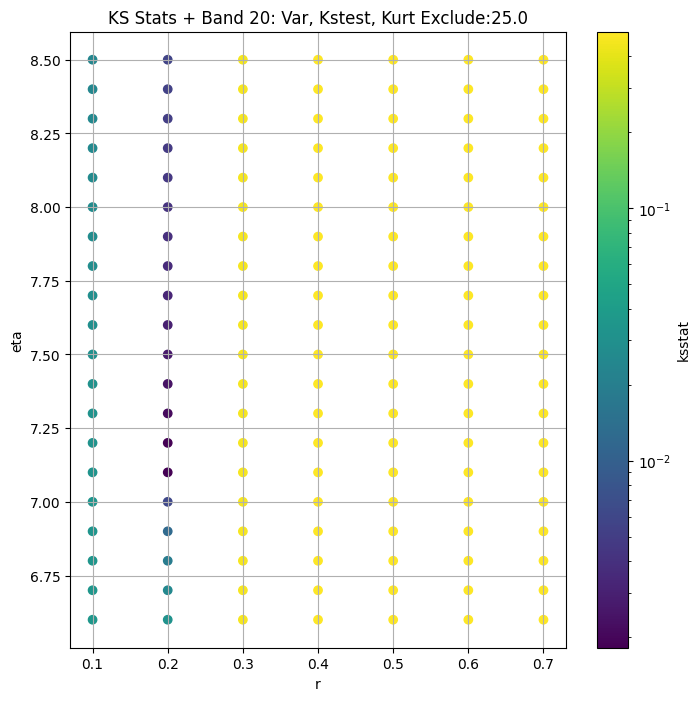

####
Band  23


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 0 0.0029490423111911968 5684016531926.229


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 25 0.0023100592358409333 5526451632876.044


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 50 0.002196425956959994 5449588005210.788


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 75 0.0025411593497103833 5384494559447.074


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 100 0.0029307561879326066 5326446832531.945


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 150 0.003716880824728524 5224058162634.342


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 200 0.004570943396357635 5134147709144.077


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 250 0.005382737410550814 5053070700995.321


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 300 0.00615820347091936 4978669155904.012


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 350 0.006901270573849677 4909643989619.494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
23 500 0.008991858042517814 4726615394651.156
Number of samples: 100000, Without approximation : 100000.0


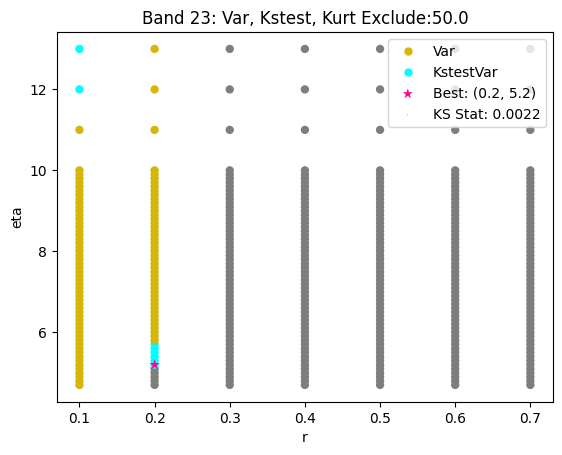

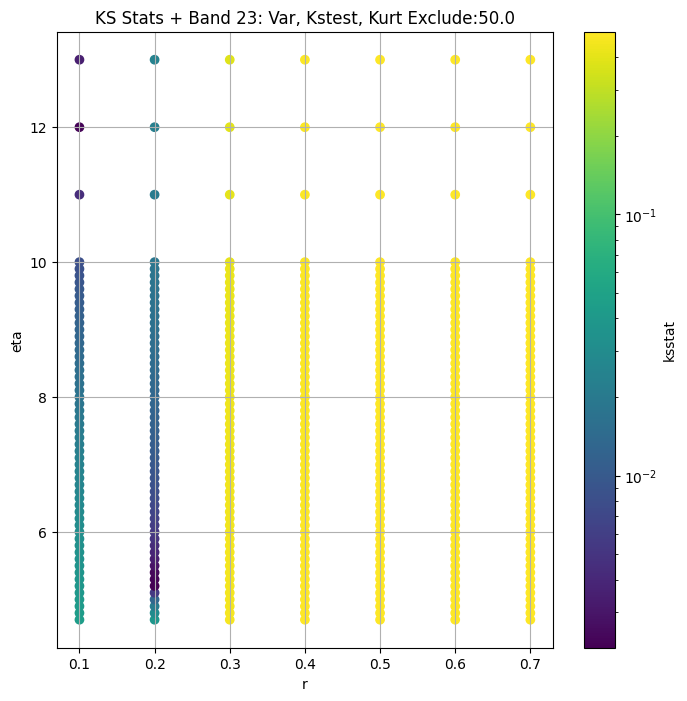

####
Band  26


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 0 0.002361174956880291 283654146645.09686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 25 0.003165798089994065 278651859259.6399


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 50 0.003702650446561151 275227812023.8157


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 75 0.00420649113591387 272243740913.98846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 100 0.004652128831550584 269539839258.31387


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 150 0.0054806419213723895 264695324983.84906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 200 0.006271269030315614 260380678748.0167


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 250 0.0070297573732430105 256442212452.61118


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 300 0.007760515119346327 252794354893.34756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 350 0.008468272245634262 249383991991.331


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
26 500 0.010473525655664104 240227881282.23993
Number of samples: 100000, Without approximation : 100000.0


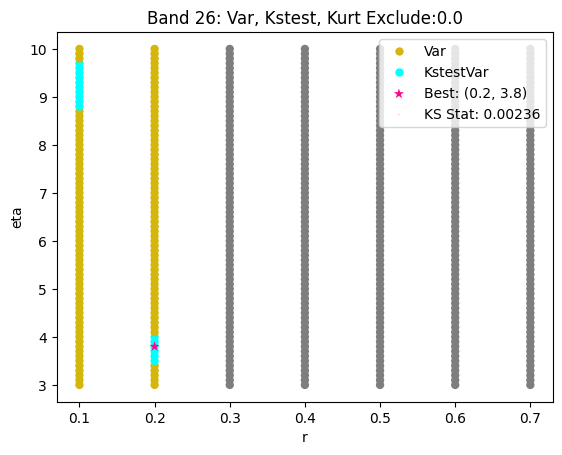

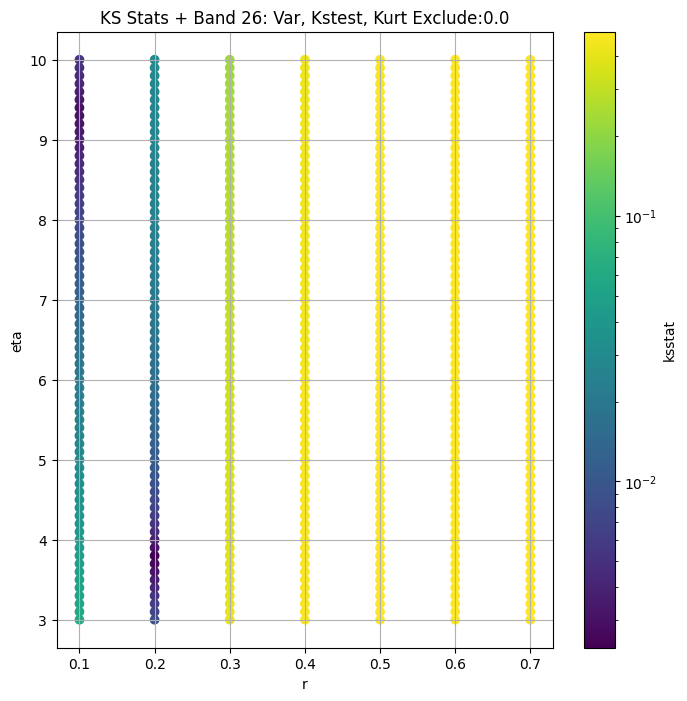

####
Band  29


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 0 0.003390491062402634 50881085560.33231


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 25 0.004175207136468365 49833712509.73375


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 50 0.004758989309363748 49109165081.48262


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 75 0.005261705968769091 48478556866.08632


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 100 0.005719375042708093 47907164469.965996


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 150 0.0065527747325831096 46886459400.22233


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 200 0.007328471739086073 45979657567.60988


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 250 0.008070539935144706 45155266453.8631


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 300 0.008788882494952119 44395256523.317955


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 350 0.009487199146251388 43687254659.65681


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
29 500 0.011491349837047804 41800965996.64368
Number of samples: 100000, Without approximation : 100000.0


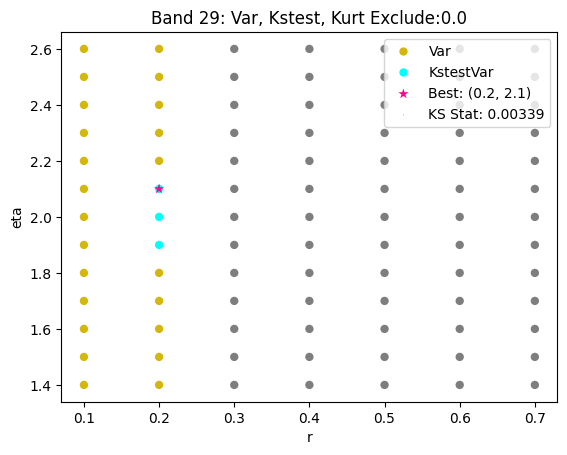

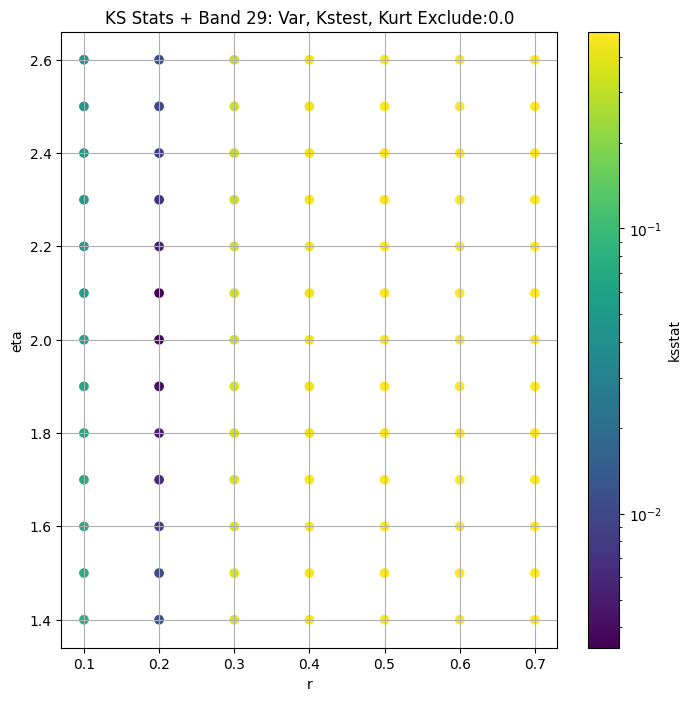

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,3.907990e+14,3.213011e+14,4.705622e+14,5.981112,3.060706,8.597465,1440.0,0.153482,0.1,9.9,7.178710e-07,0.0,3.907990e+14,0.035671
5,8.619868e+14,7.597638e+14,9.705736e+14,20.513369,17.319409,23.942896,14400.0,0.020931,0.1,6.9,1.106182e-05,200.0,3.243172e+14,0.011306
8,1.826341e+14,1.574274e+14,2.108616e+14,30.720031,21.959829,41.223043,27360.0,0.017674,0.1,8.7,3.845455e-07,300.0,7.192226e+13,0.008204
11,1.413384e+13,1.141042e+13,1.895579e+13,105.616169,12.570871,283.376403,56160.0,0.004340,0.2,9.4,1.650016e+04,150.0,9.485270e+12,0.005728
14,3.339637e+14,3.084108e+14,3.620677e+14,7.901885,5.022119,12.454595,100000.0,0.067749,0.1,5.2,9.269776e-05,50.0,3.210852e+14,0.004293
17,4.391542e+14,4.184581e+14,4.612009e+14,1.599081,1.112939,2.882672,100000.0,0.006790,0.1,14.0,4.127761e-08,0.0,4.391542e+14,0.004293
20,1.863235e+13,1.759787e+13,1.997386e+13,3.611286,1.579866,15.278751,100000.0,0.001820,0.2,7.1,9.927073e+04,25.0,1.827303e+13,0.004293
23,5.684017e+12,5.313017e+12,6.385912e+12,9.221800,2.312359,81.392754,100000.0,0.002196,0.2,5.2,9.703922e+04,50.0,5.449588e+12,0.004293
26,2.836541e+11,2.676022e+11,3.008791e+11,3.267833,2.205742,6.772957,100000.0,0.002361,0.2,3.8,1.517902e+04,0.0,2.836541e+11,0.004293


In [13]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 2, 0.0 + 100 = 100, ksstat: 0.22332578270947098, var: 130916957148344.4


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 2, 0.0 + 75 = 75, ksstat: 0.2066017949430634, var: 154004478557263.47


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 2, 0.0 + 50 = 50, ksstat: 0.18842603319485335, var: 184925845292006.4


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 2, 0.0 + 25 = 25, ksstat: 0.16704035427522412, var: 231975987365711.56


  0%|          | 0/347 [00:00<?, ?it/s]

Finding Minimum after computing 347 CDFs
band 2, 0.0 + 0 = 0, ksstat: 0.15348214205873856, var: 390799019528792.25
Number of samples: 1440, Without approximation : 1440.0


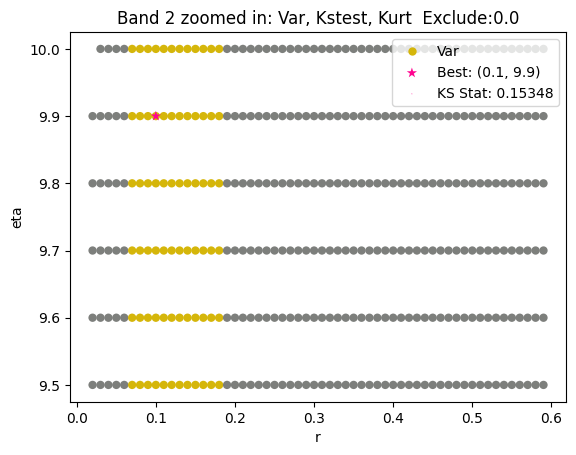

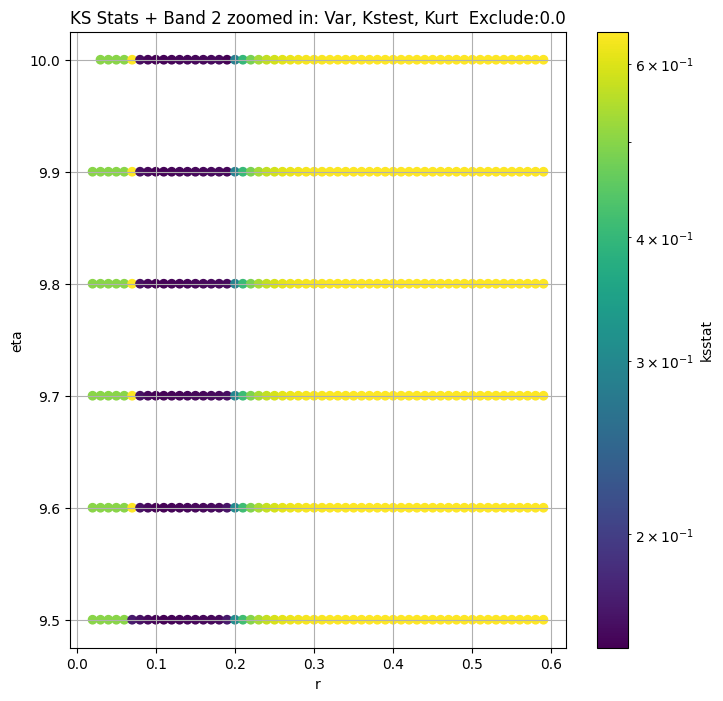

Band 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 200.0 + 100 = 300, ksstat: 0.02595080724068599, var: 249913289487294.38


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 200.0 + 75 = 275, ksstat: 0.024682239108309023, var: 265138342554394.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 200.0 + 50 = 250, ksstat: 0.02335830897890212, var: 282460943583035.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 200.0 + 25 = 225, ksstat: 0.022042994595109167, var: 301906155188577.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 200.0 + 0 = 200, ksstat: 0.020931029322034278, var: 324317231619331.44


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 200.0 + -25 = 175, ksstat: 0.021037088075622434, var: 350504804069393.25


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 200.0 + -50 = 150, ksstat: 0.021186395404155484, var: 380737460576580.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 200.0 + -75 = 125, ksstat: 0.02139861743538185, var: 417048566192706.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 5, 200.0 + -100 = 100, ksstat: 0.022347840693484874, var: 460494673480690.75
Number of samples: 14400, Without approximation : 14400.0


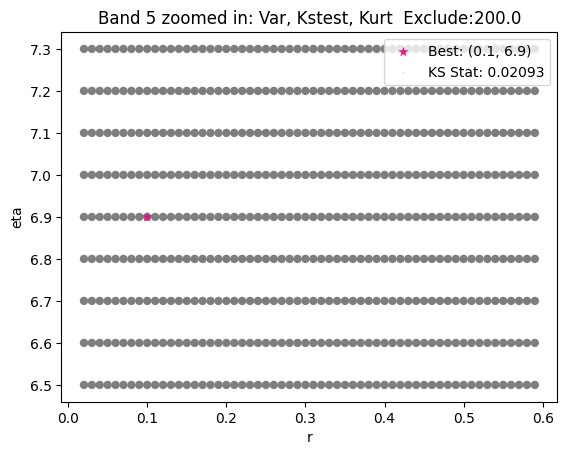

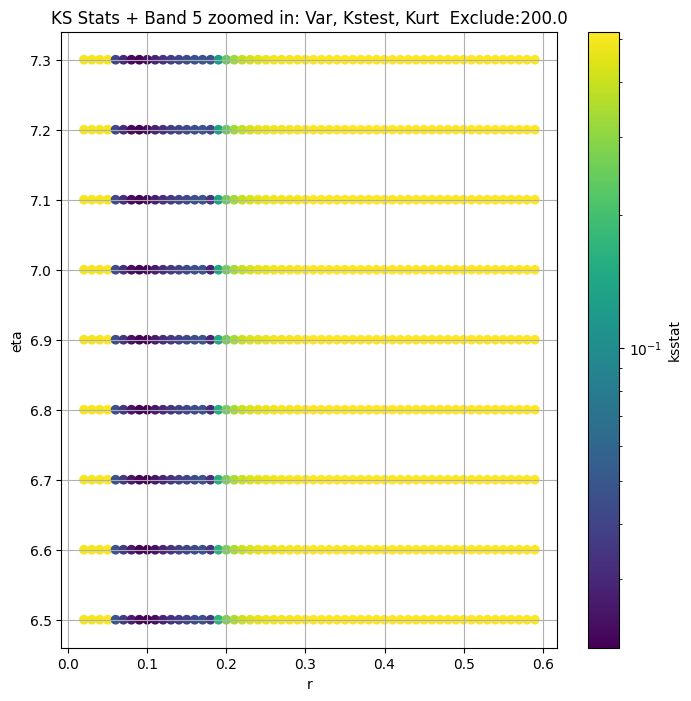

Band 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 300.0 + 100 = 400, ksstat: 0.019398205084827733, var: 61955309042314.97


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 300.0 + 75 = 375, ksstat: 0.018558247992353172, var: 64108749007369.97


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 300.0 + 50 = 350, ksstat: 0.01784581030422356, var: 66444117468162.836


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 300.0 + 25 = 325, ksstat: 0.017663799991971874, var: 69027494816604.75


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 300.0 + 0 = 300, ksstat: 0.017674195245220847, var: 71922259724579.78


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 300.0 + -25 = 275, ksstat: 0.017740491226857502, var: 75082729033619.52


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 300.0 + -50 = 250, ksstat: 0.017635862010825232, var: 78580268850338.05


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 300.0 + -75 = 225, ksstat: 0.01834019685664956, var: 82626397276740.27


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 8, 300.0 + -100 = 200, ksstat: 0.02000156029889072, var: 87105180768094.12
Number of samples: 27360, Without approximation : 27360.0


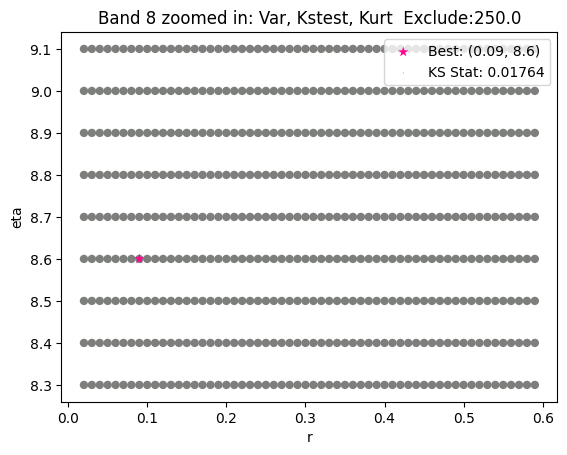

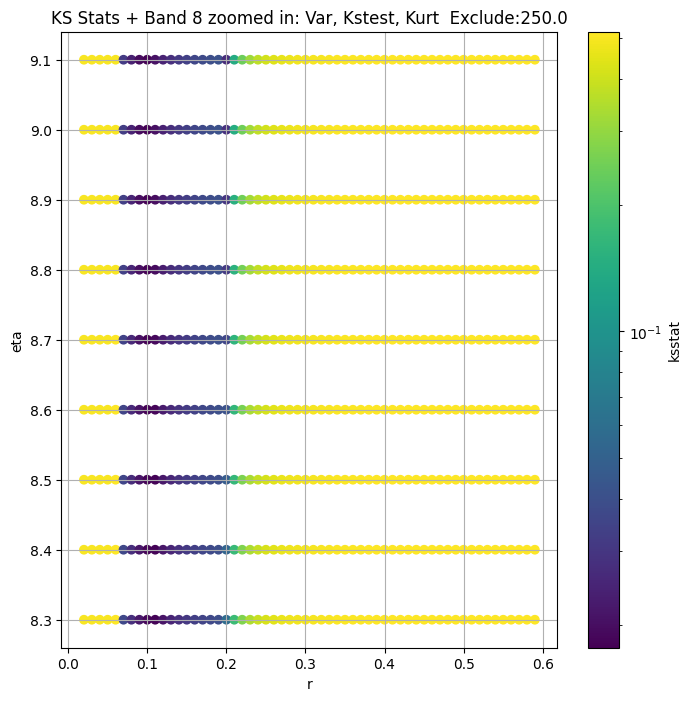

Band 11


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 100 = 250, ksstat: 0.008972778070543086, var: 8885967046512.611


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 75 = 225, ksstat: 0.007463985281959573, var: 9013800711312.045


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 50 = 200, ksstat: 0.005839897534935079, var: 9153794424162.377


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 25 = 175, ksstat: 0.004685912024824823, var: 9311823873337.723


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + 0 = 150, ksstat: 0.004340069467471341, var: 9485269804228.3


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -25 = 125, ksstat: 0.004042522667284637, var: 9677575658834.03


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -50 = 100, ksstat: 0.004931242037872541, var: 9899330680480.291


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -75 = 75, ksstat: 0.005939228648597902, var: 10167952680545.52


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 11, 150.0 + -100 = 50, ksstat: 0.007361432993142326, var: 10536470092058.898
Number of samples: 56160, Without approximation : 56160.0


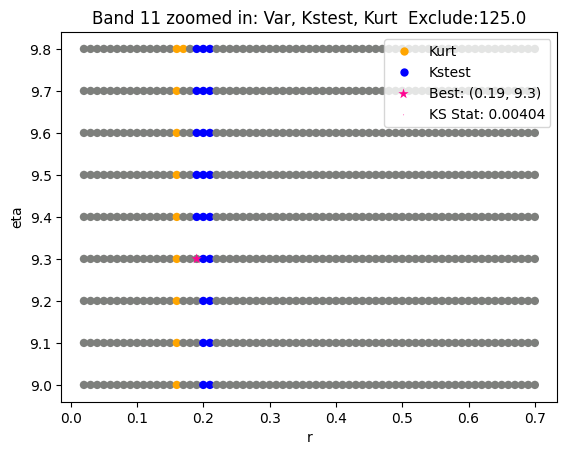

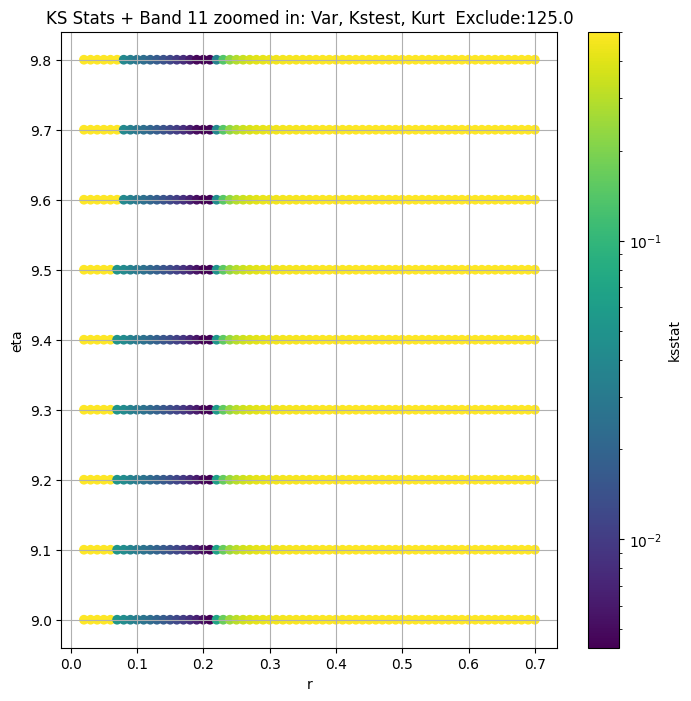

Band 14


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 50.0 + 100 = 150, ksstat: 0.06853190806128695, var: 307605878001531.25


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 50.0 + 75 = 125, ksstat: 0.06835273050169627, var: 310535489102336.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 50.0 + 50 = 100, ksstat: 0.0681360118763212, var: 313696783546832.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 50.0 + 25 = 75, ksstat: 0.06787569400656548, var: 317158793601955.2


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 50.0 + 0 = 50, ksstat: 0.06774889089286174, var: 321085241500707.8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 50.0 + -25 = 25, ksstat: 0.06796390921703327, var: 325843945987703.06


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
band 14, 50.0 + -50 = 0, ksstat: 0.06852201410154035, var: 333963696397857.75
Number of samples: 100000, Without approximation : 100000.0


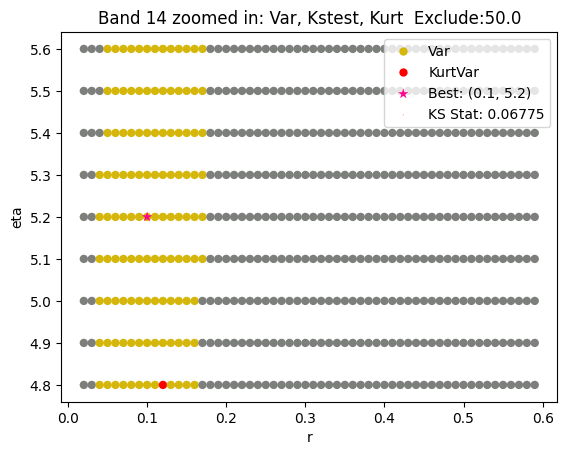

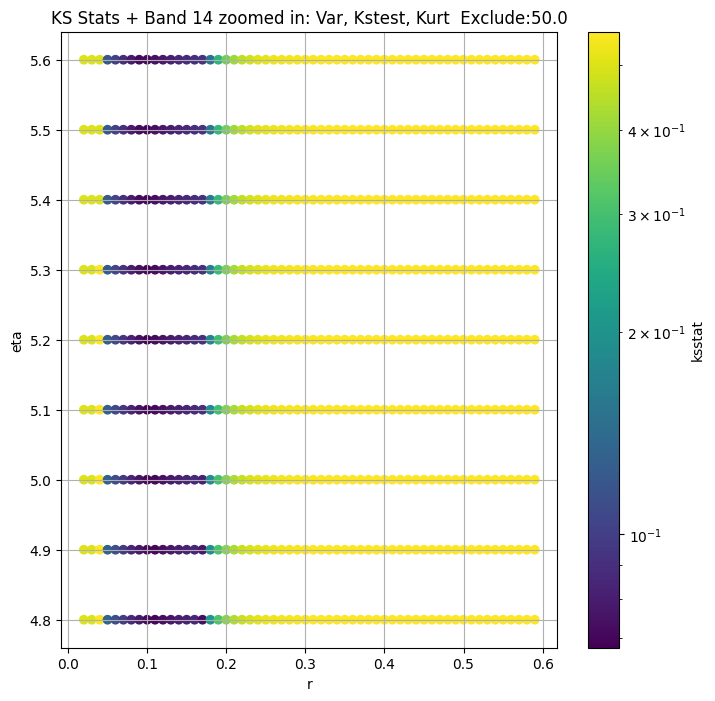

Band 17


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 17, 0.0 + 100 = 100, ksstat: 0.005730359809748883, var: 423224175872057.6


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 17, 0.0 + 75 = 75, ksstat: 0.005090662483107897, var: 426410848029660.2


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 17, 0.0 + 50 = 50, ksstat: 0.005247817070320834, var: 429884128734079.56


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 17, 0.0 + 25 = 25, ksstat: 0.004461410913045485, var: 433796998308295.7


  0%|          | 0/57 [00:00<?, ?it/s]

Finding Minimum after computing 57 CDFs
band 17, 0.0 + 0 = 0, ksstat: 0.004565530506988852, var: 439154200765636.44
Number of samples: 100000, Without approximation : 100000.0


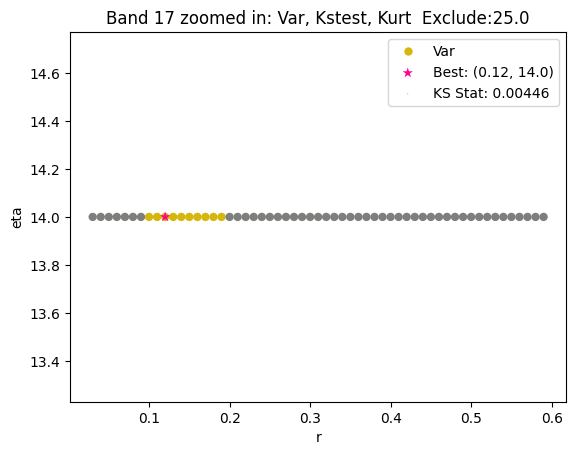

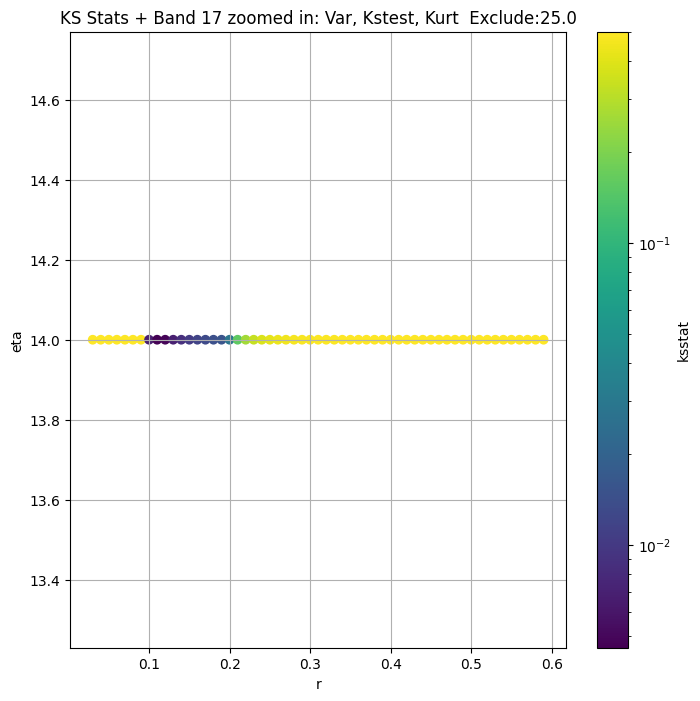

Band 20


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 20, 25.0 + 100 = 125, ksstat: 0.0034911360772636527, var: 17585118798659.47


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 20, 25.0 + 75 = 100, ksstat: 0.0030263488679326336, var: 17733097500663.0


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 20, 25.0 + 50 = 75, ksstat: 0.002594822966891952, var: 17892983581297.12


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 20, 25.0 + 25 = 50, ksstat: 0.0021493389279683695, var: 18069217417831.375


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 20, 25.0 + 0 = 25, ksstat: 0.0017605694577674056, var: 18273028688962.547


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 20, 25.0 + -25 = 0, ksstat: 0.0020096434040796085, var: 18632354905639.773
Number of samples: 100000, Without approximation : 100000.0


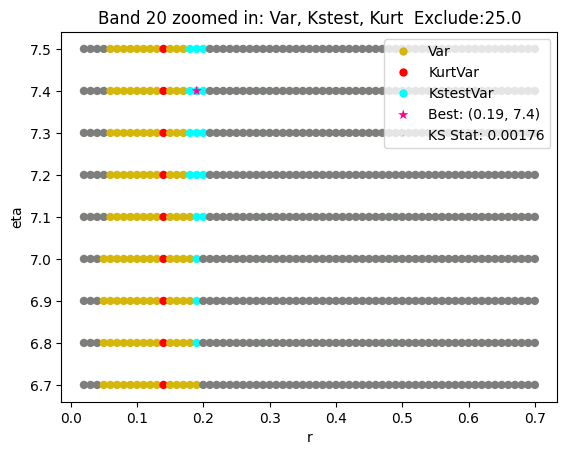

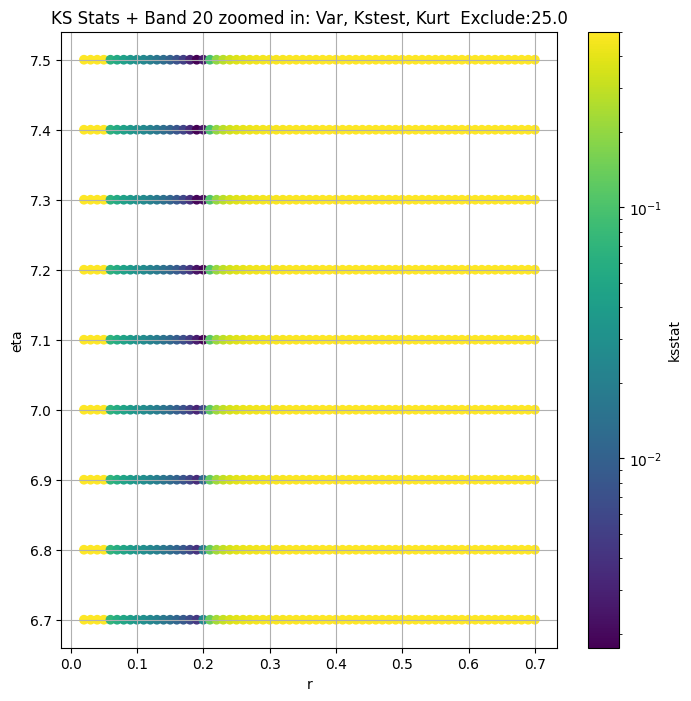

Band 23


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 100 = 150, ksstat: 0.003716880824728524, var: 5224058162634.342


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 75 = 125, ksstat: 0.0033186769452153604, var: 5273362482951.841


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 50 = 100, ksstat: 0.0029146554446990297, var: 5326446832531.945


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 25 = 75, ksstat: 0.0025252792817615465, var: 5384494559447.074


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + 0 = 50, ksstat: 0.002124425243557755, var: 5449588005210.788


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + -25 = 25, ksstat: 0.001938862239671768, var: 5526451632876.044


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 23, 50.0 + -50 = 0, ksstat: 0.002700502448141795, var: 5684016531926.229
Number of samples: 100000, Without approximation : 100000.0


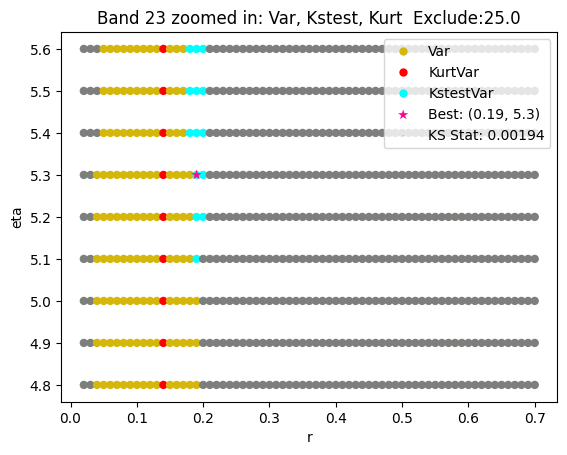

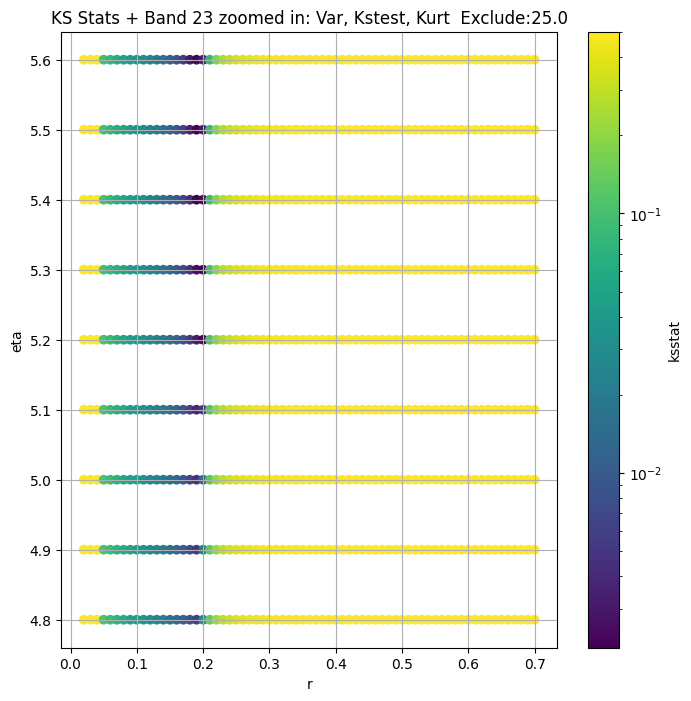

Band 26


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 26, 0.0 + 100 = 100, ksstat: 0.004570181048731192, var: 269539839258.31387


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 26, 0.0 + 75 = 75, ksstat: 0.004061970970518317, var: 272243740913.98846


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 26, 0.0 + 50 = 50, ksstat: 0.003589578009352355, var: 275227812023.8157


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 26, 0.0 + 25 = 25, ksstat: 0.00304237301850753, var: 278651859259.6399


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 26, 0.0 + 0 = 0, ksstat: 0.002361174956880291, var: 283654146645.09686
Number of samples: 100000, Without approximation : 100000.0


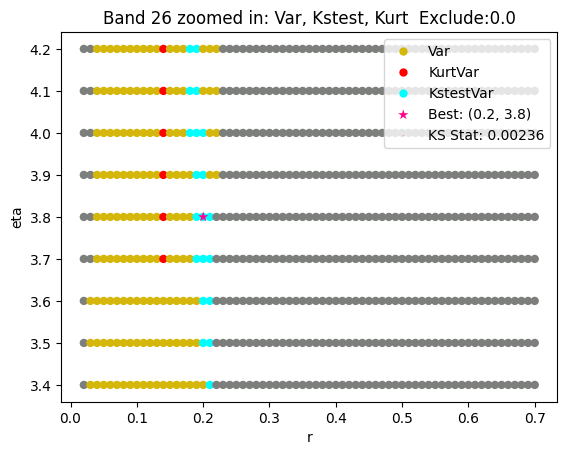

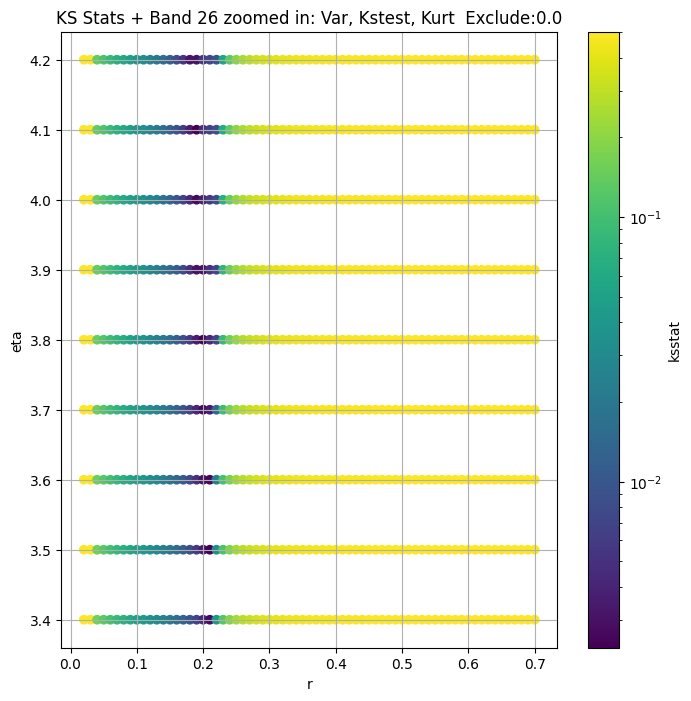

Band 29


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 29, 0.0 + 100 = 100, ksstat: 0.005616044708761626, var: 47907164469.965996


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 29, 0.0 + 75 = 75, ksstat: 0.005195596136400797, var: 48478556866.08632


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 29, 0.0 + 50 = 50, ksstat: 0.004704880136669719, var: 49109165081.48262


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 29, 0.0 + 25 = 25, ksstat: 0.004138089177058324, var: 49833712509.73375


  0%|          | 0/621 [00:00<?, ?it/s]

Finding Minimum after computing 621 CDFs
band 29, 0.0 + 0 = 0, ksstat: 0.003218416473334207, var: 50881085560.33231
Number of samples: 100000, Without approximation : 100000.0


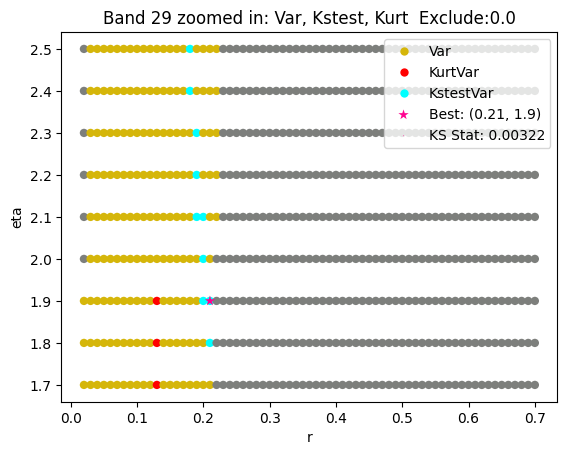

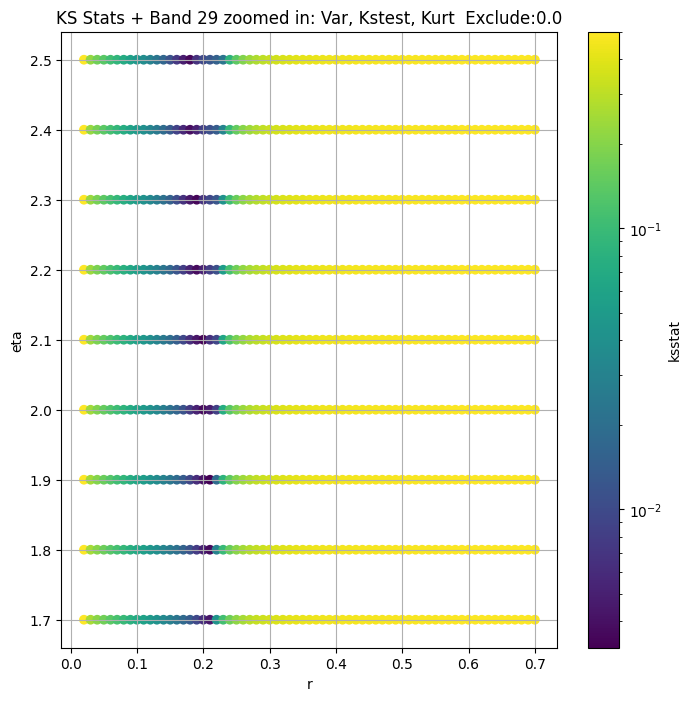

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,3.907990e+14,3.213011e+14,4.705622e+14,5.981112,3.060706,8.597465,1440.0,0.153482,0.1,9.9,7.178710e-07,0.0,3.907990e+14,0.035671,0.153482,0.10,9.9,7.178710e-07,0.0,75
5,8.619868e+14,7.597638e+14,9.705736e+14,20.513369,17.319409,23.942896,14400.0,0.020931,0.1,6.9,1.106182e-05,200.0,3.243172e+14,0.011306,0.020931,0.10,6.9,1.106182e-05,200.0,4050
8,1.826341e+14,1.574274e+14,2.108616e+14,30.720031,21.959829,41.223043,27360.0,0.017674,0.1,8.7,3.845455e-07,300.0,7.858027e+13,0.008204,0.017636,0.09,8.6,8.050428e-10,250.0,5770
11,1.413384e+13,1.141042e+13,1.895579e+13,105.616169,12.570871,283.376403,56160.0,0.004340,0.2,9.4,1.650016e+04,150.0,9.677576e+12,0.005728,0.004043,0.19,9.3,4.647765e+03,125.0,113848
14,3.339637e+14,3.084108e+14,3.620677e+14,7.901885,5.022119,12.454595,100000.0,0.067749,0.1,5.2,9.269776e-05,50.0,3.210852e+14,0.004293,0.067749,0.10,5.2,9.269776e-05,50.0,390
17,4.391542e+14,4.184581e+14,4.612009e+14,1.599081,1.112939,2.882672,100000.0,0.006790,0.1,14.0,4.127761e-08,0.0,4.337970e+14,0.004293,0.004461,0.12,14.0,8.783064e-04,25.0,94921
20,1.863235e+13,1.759787e+13,1.997386e+13,3.611286,1.579866,15.278751,100000.0,0.001820,0.2,7.1,9.927073e+04,25.0,1.827303e+13,0.004293,0.001761,0.19,7.4,2.335236e+04,25.0,569530
23,5.684017e+12,5.313017e+12,6.385912e+12,9.221800,2.312359,81.392754,100000.0,0.002196,0.2,5.2,9.703922e+04,50.0,5.526452e+12,0.004293,0.001939,0.19,5.3,2.718444e+04,25.0,506250
26,2.836541e+11,2.676022e+11,3.008791e+11,3.267833,2.205742,6.772957,100000.0,0.002361,0.2,3.8,1.517902e+04,0.0,2.836541e+11,0.004293,0.002361,0.20,3.8,1.517902e+04,0.0,337500


In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

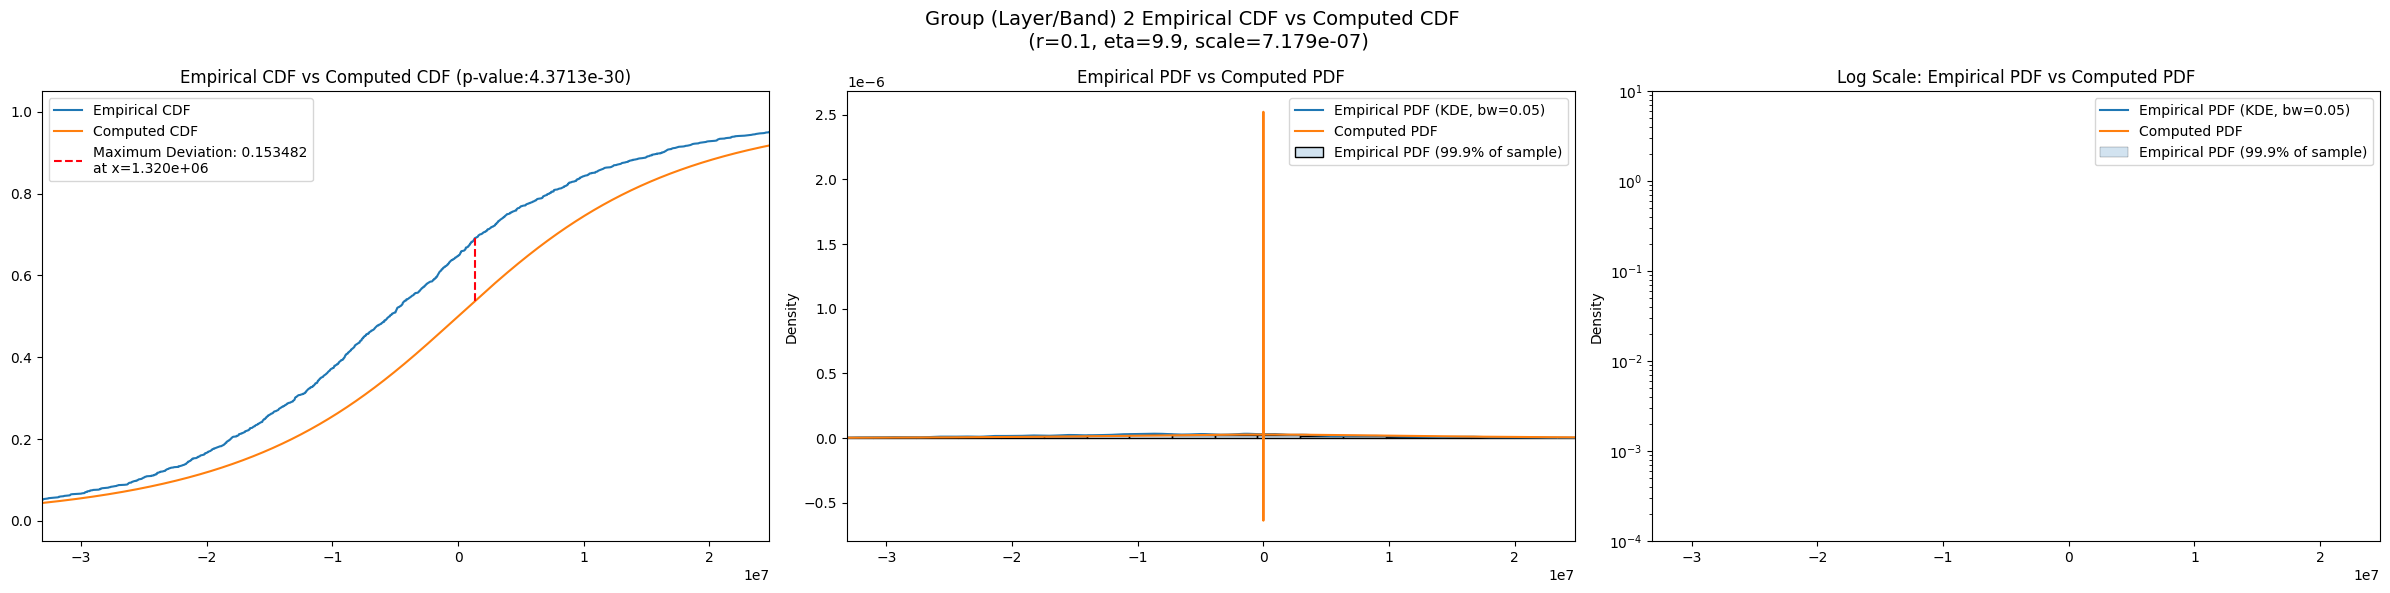

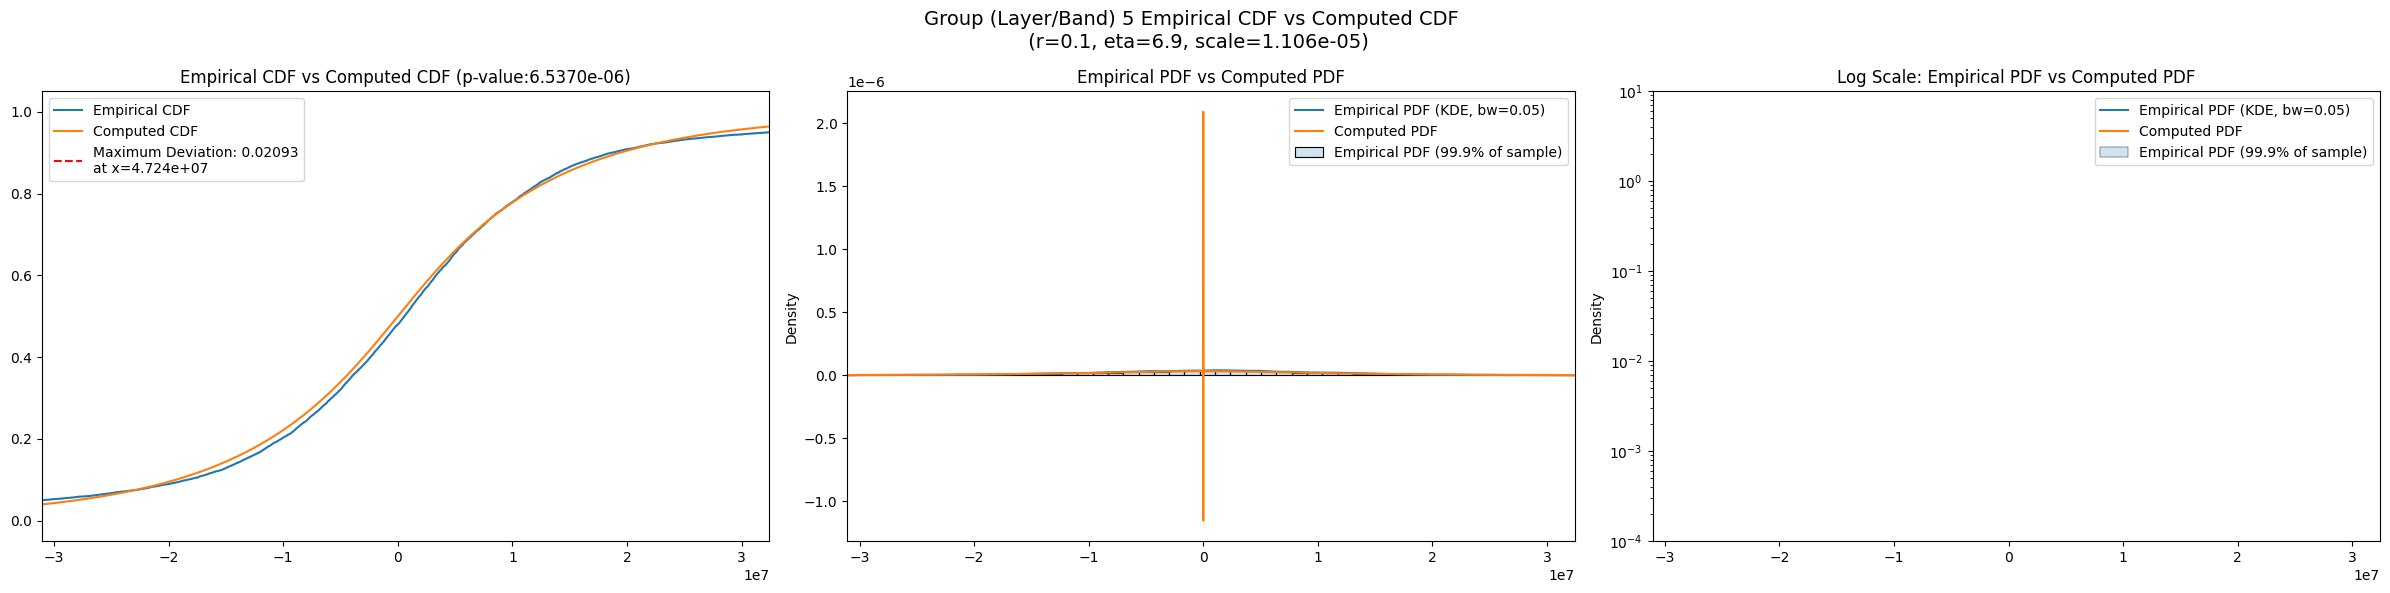

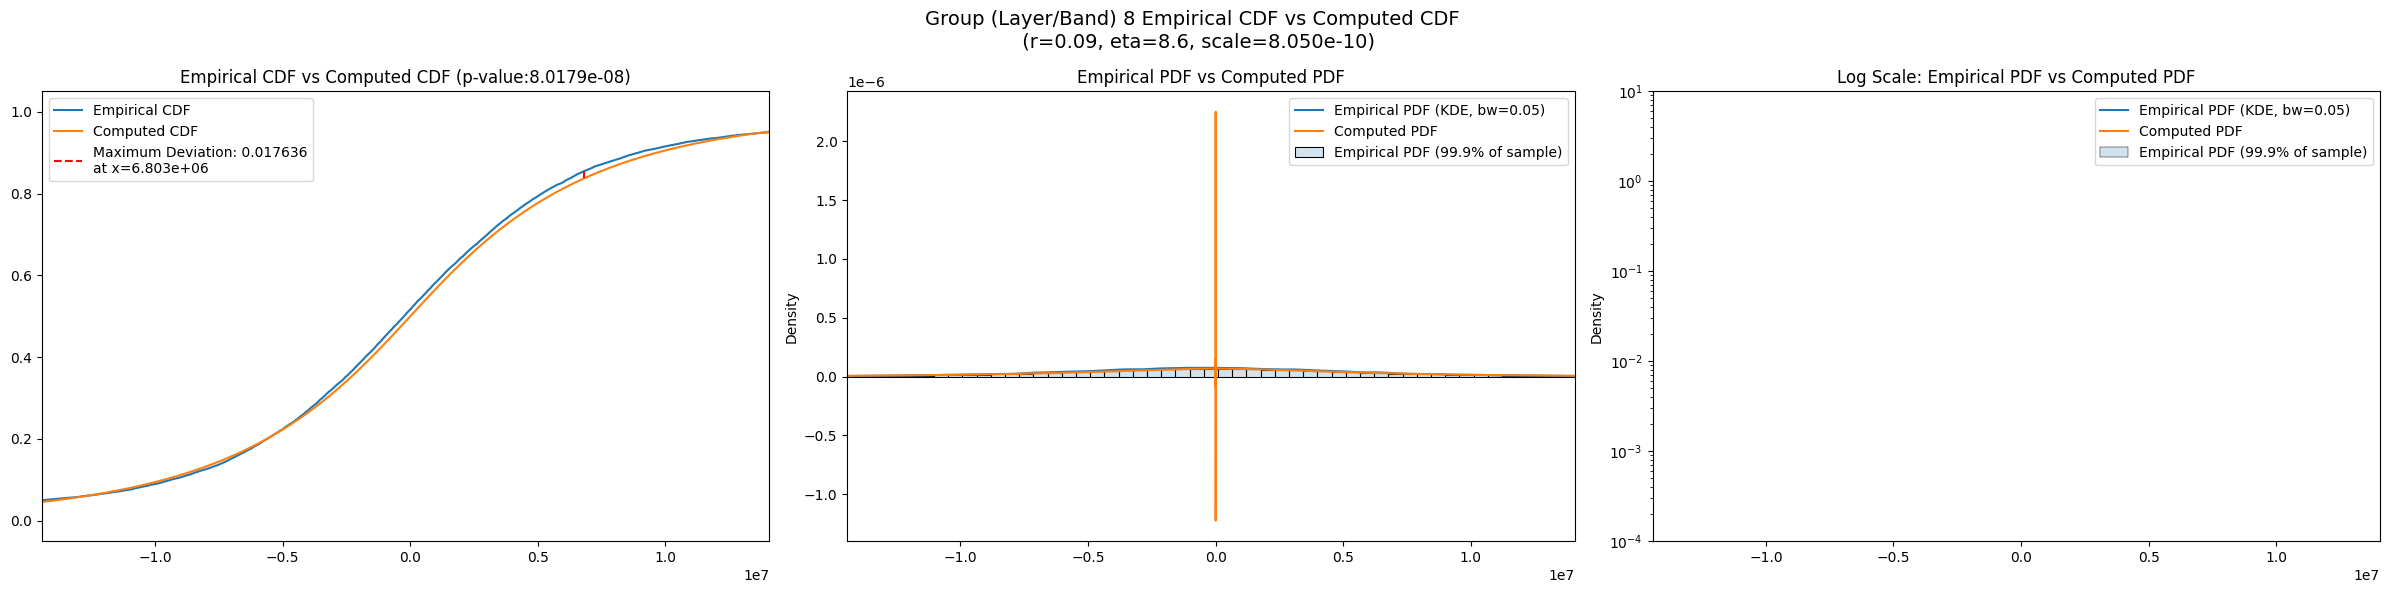

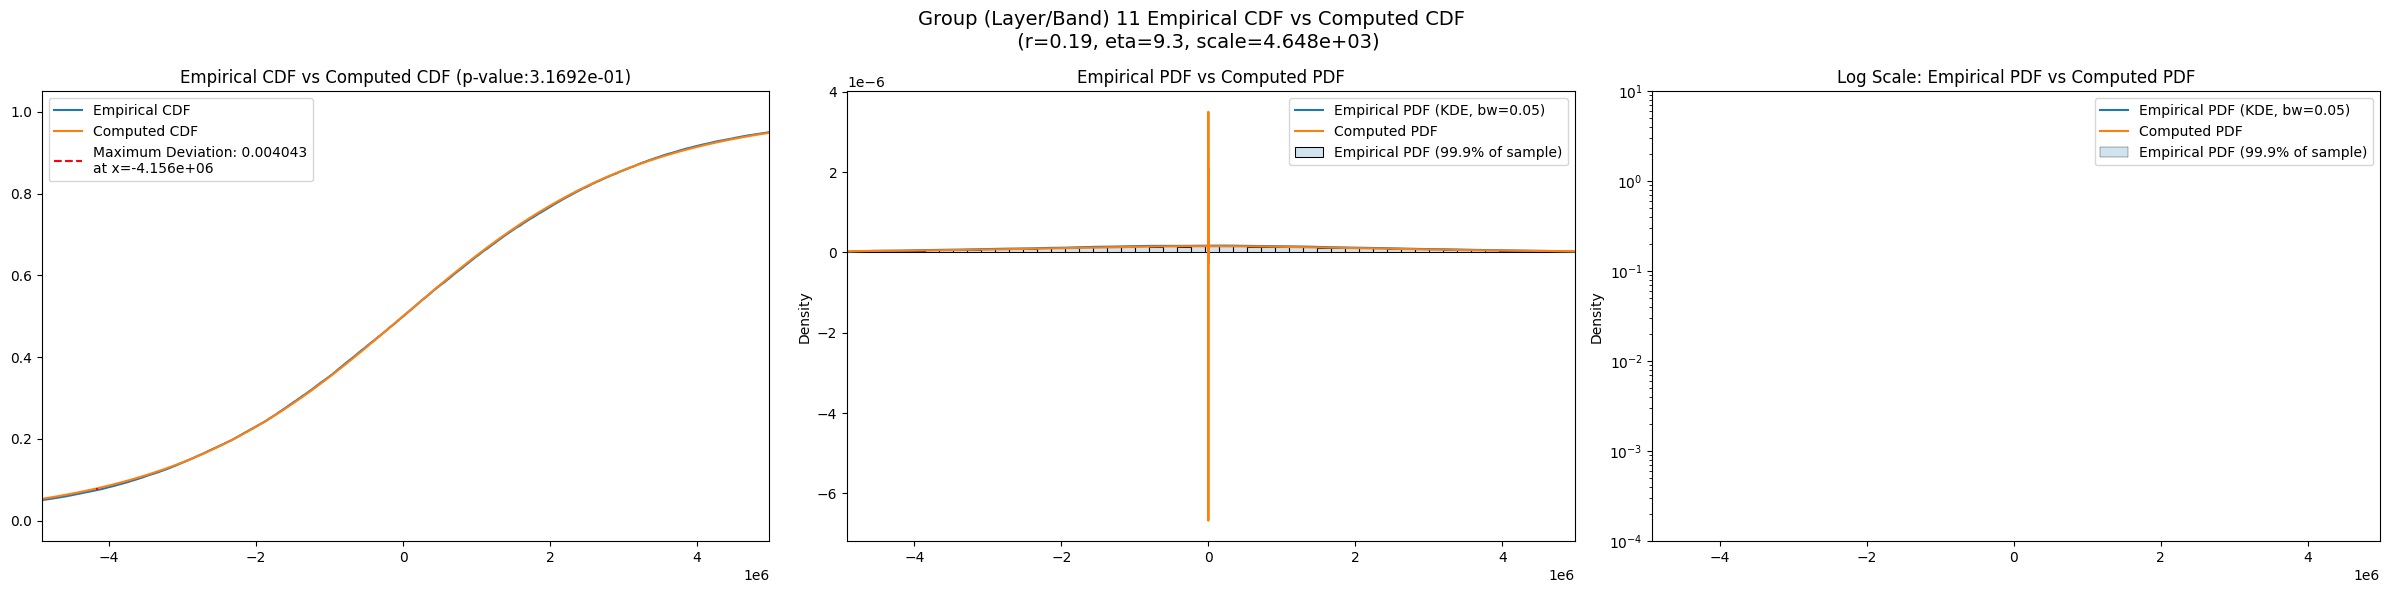

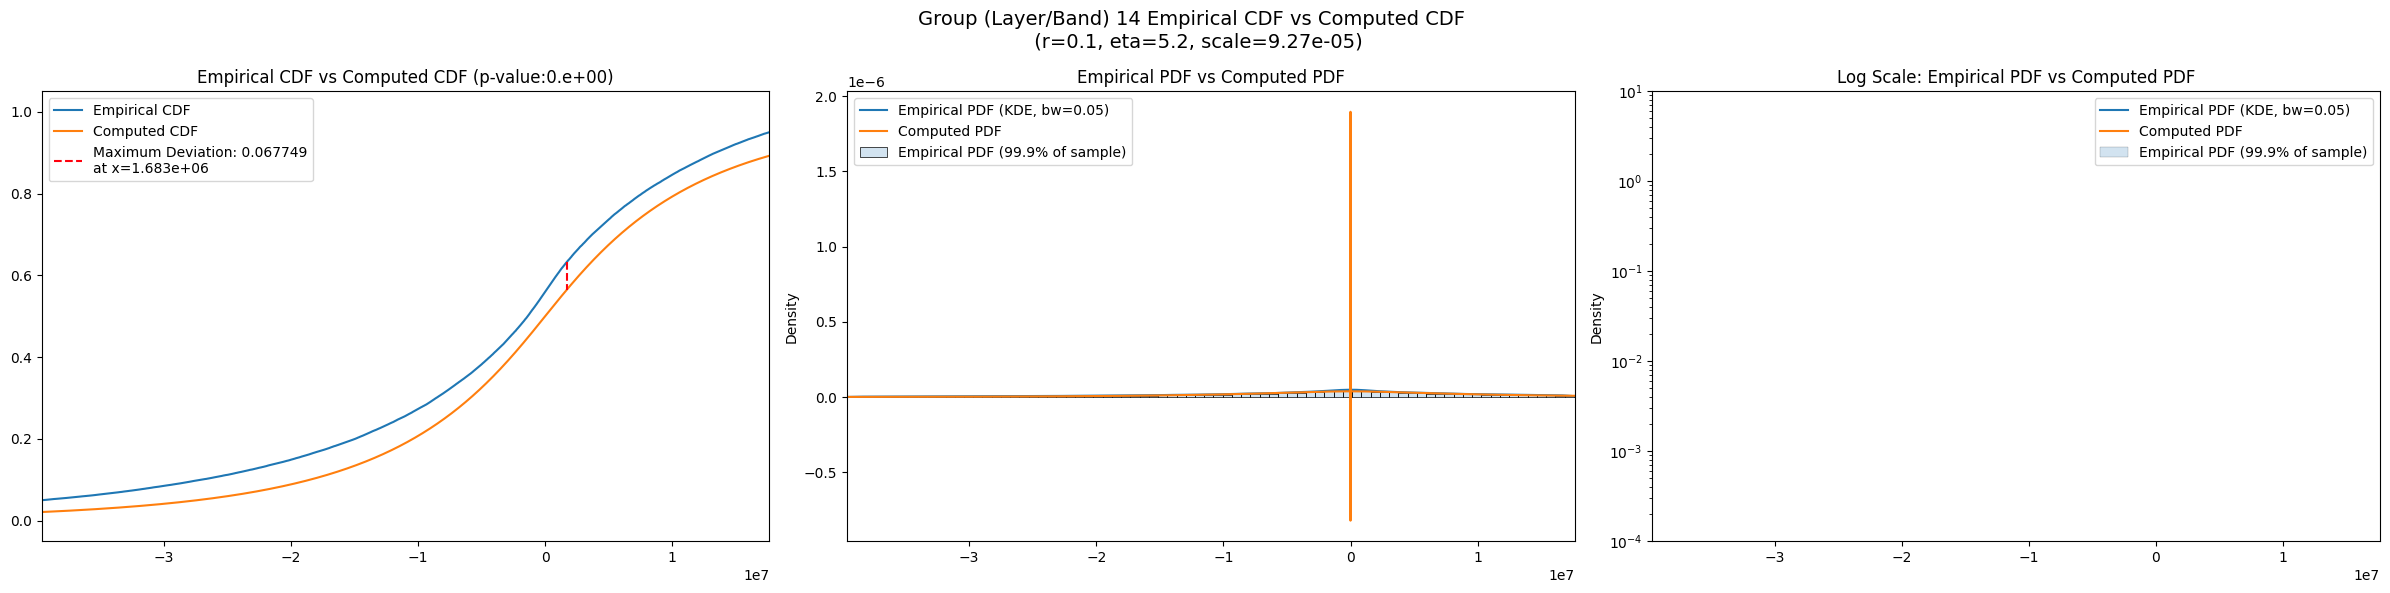

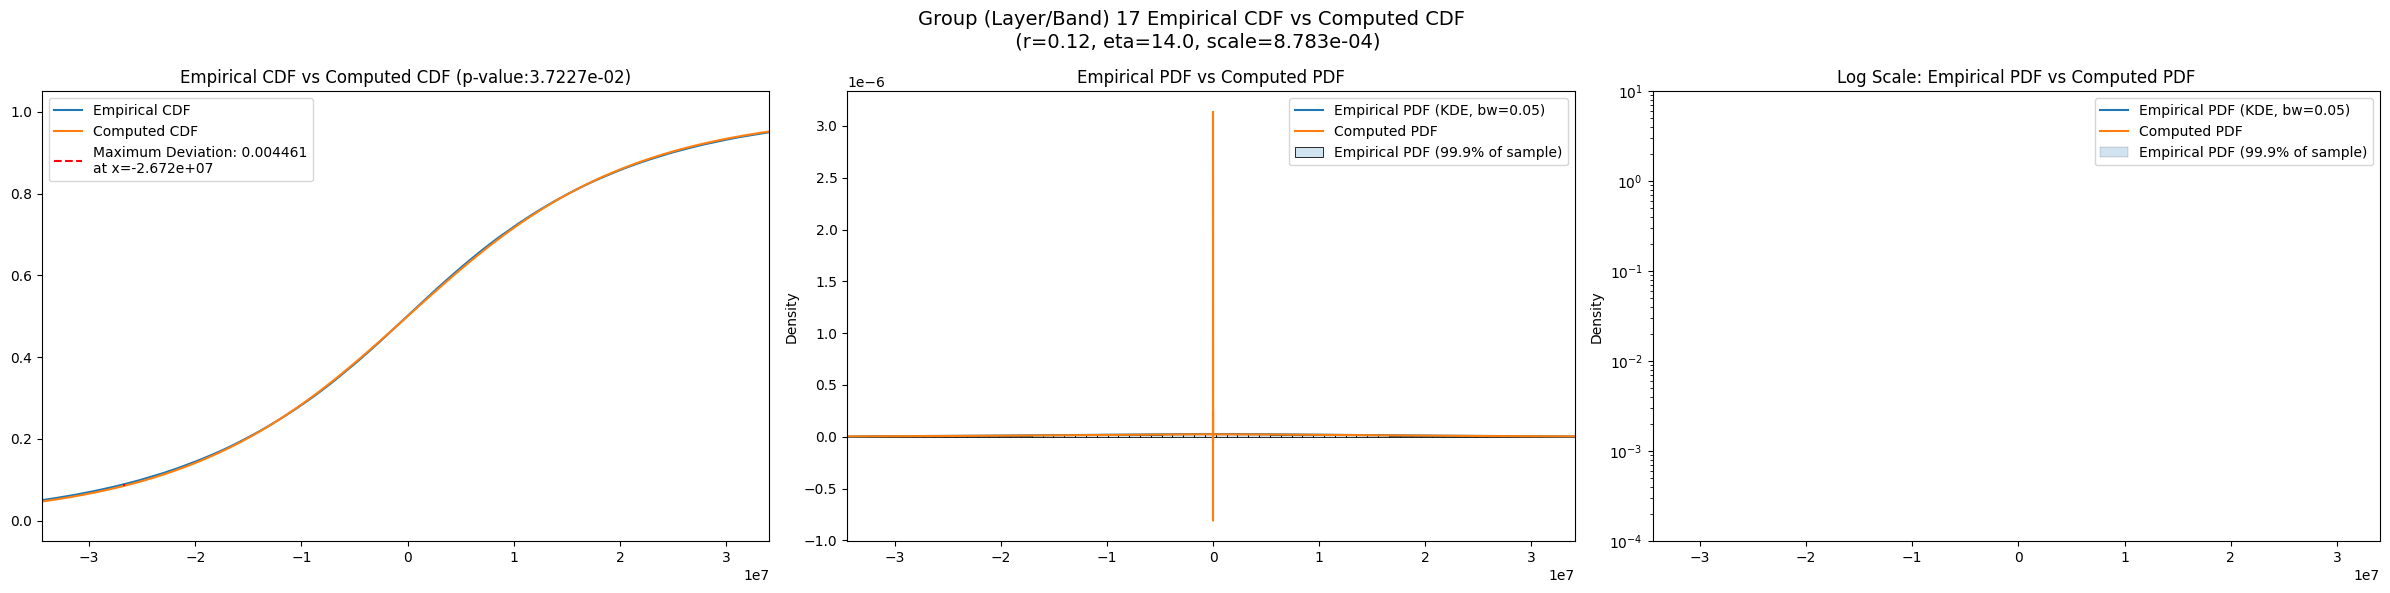

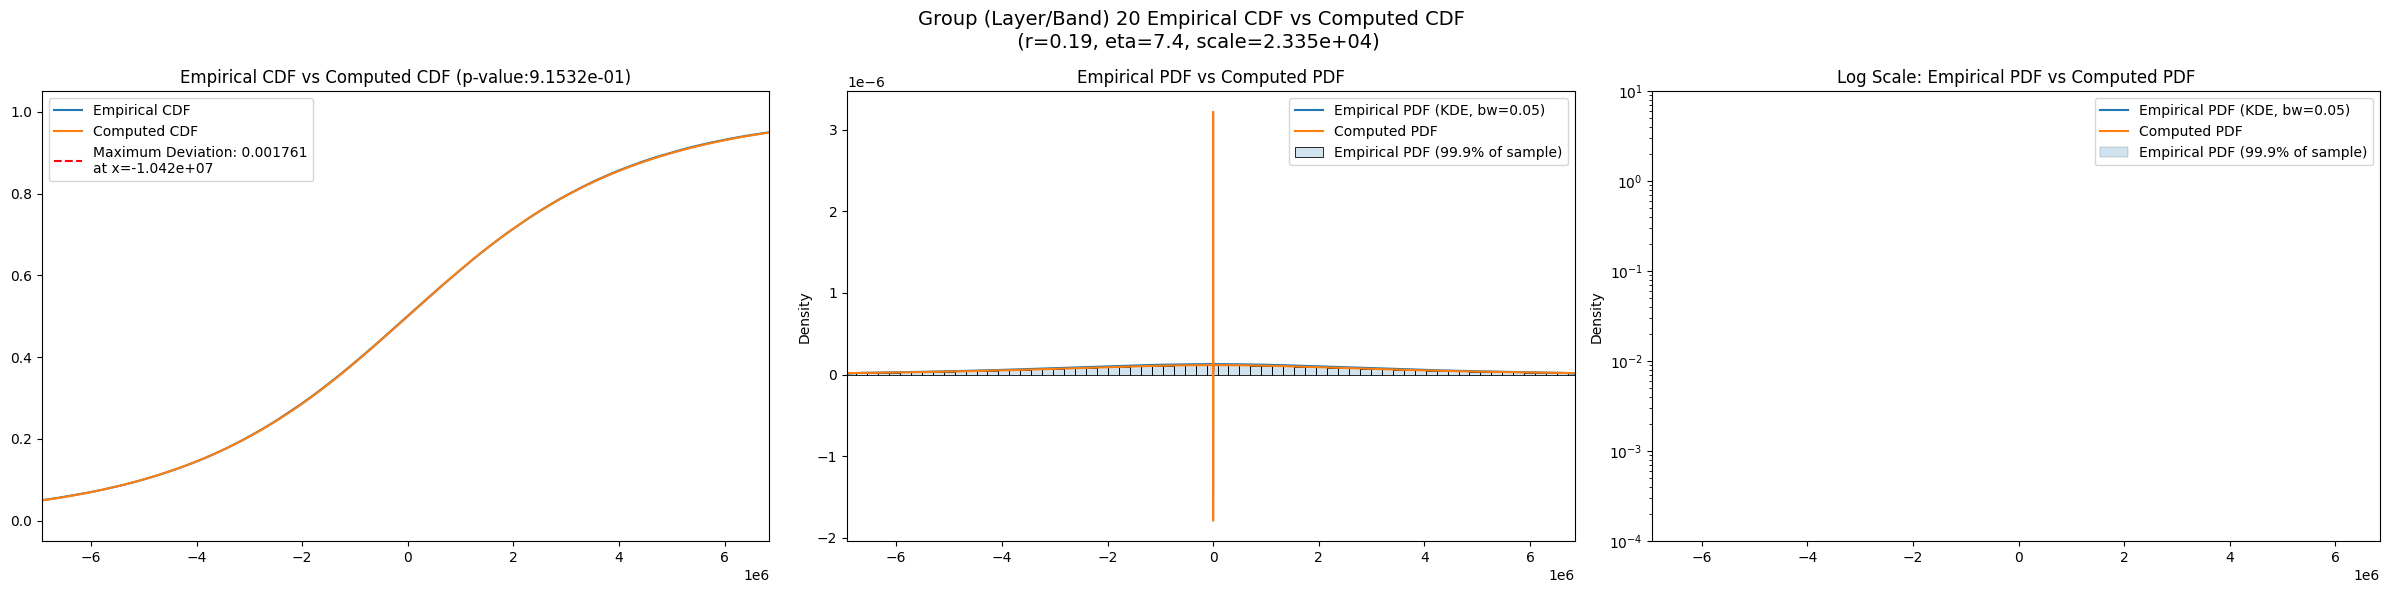

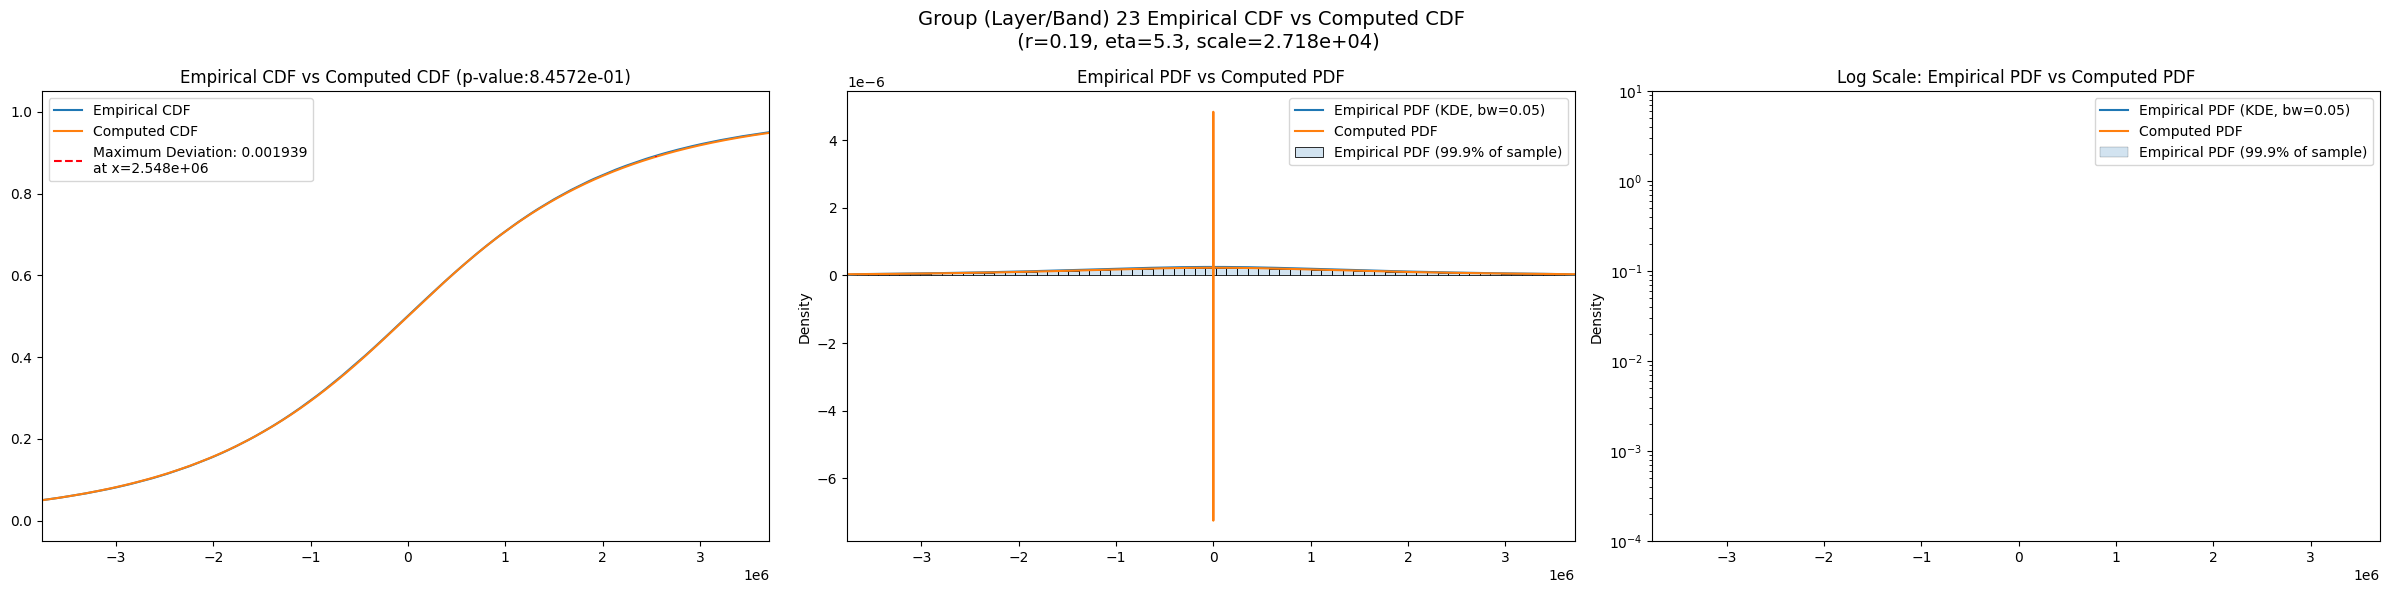

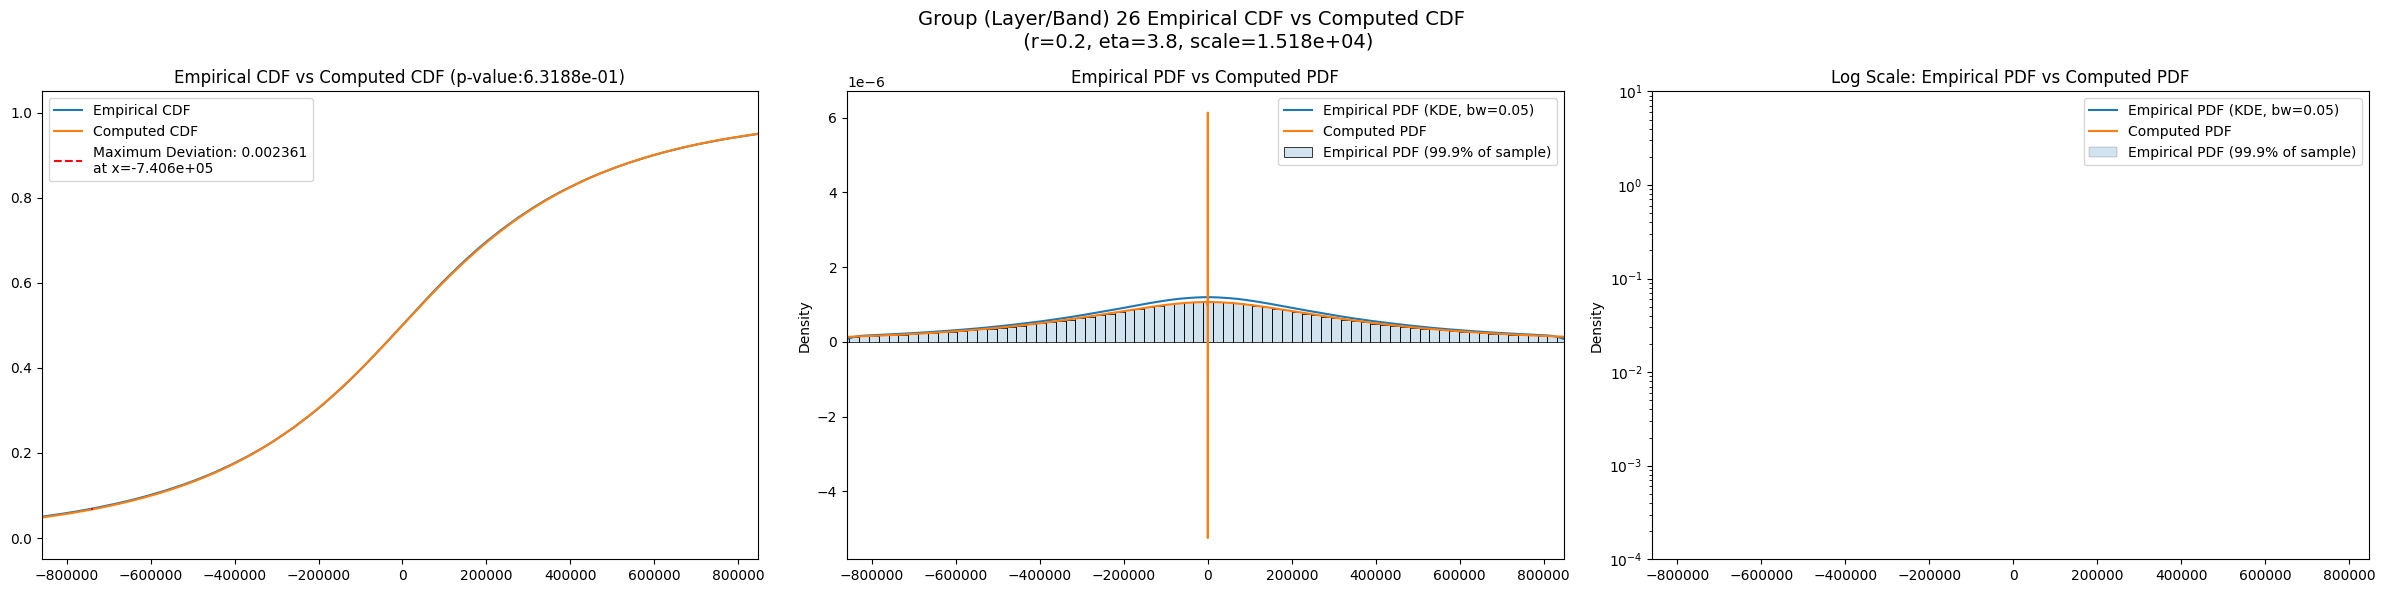

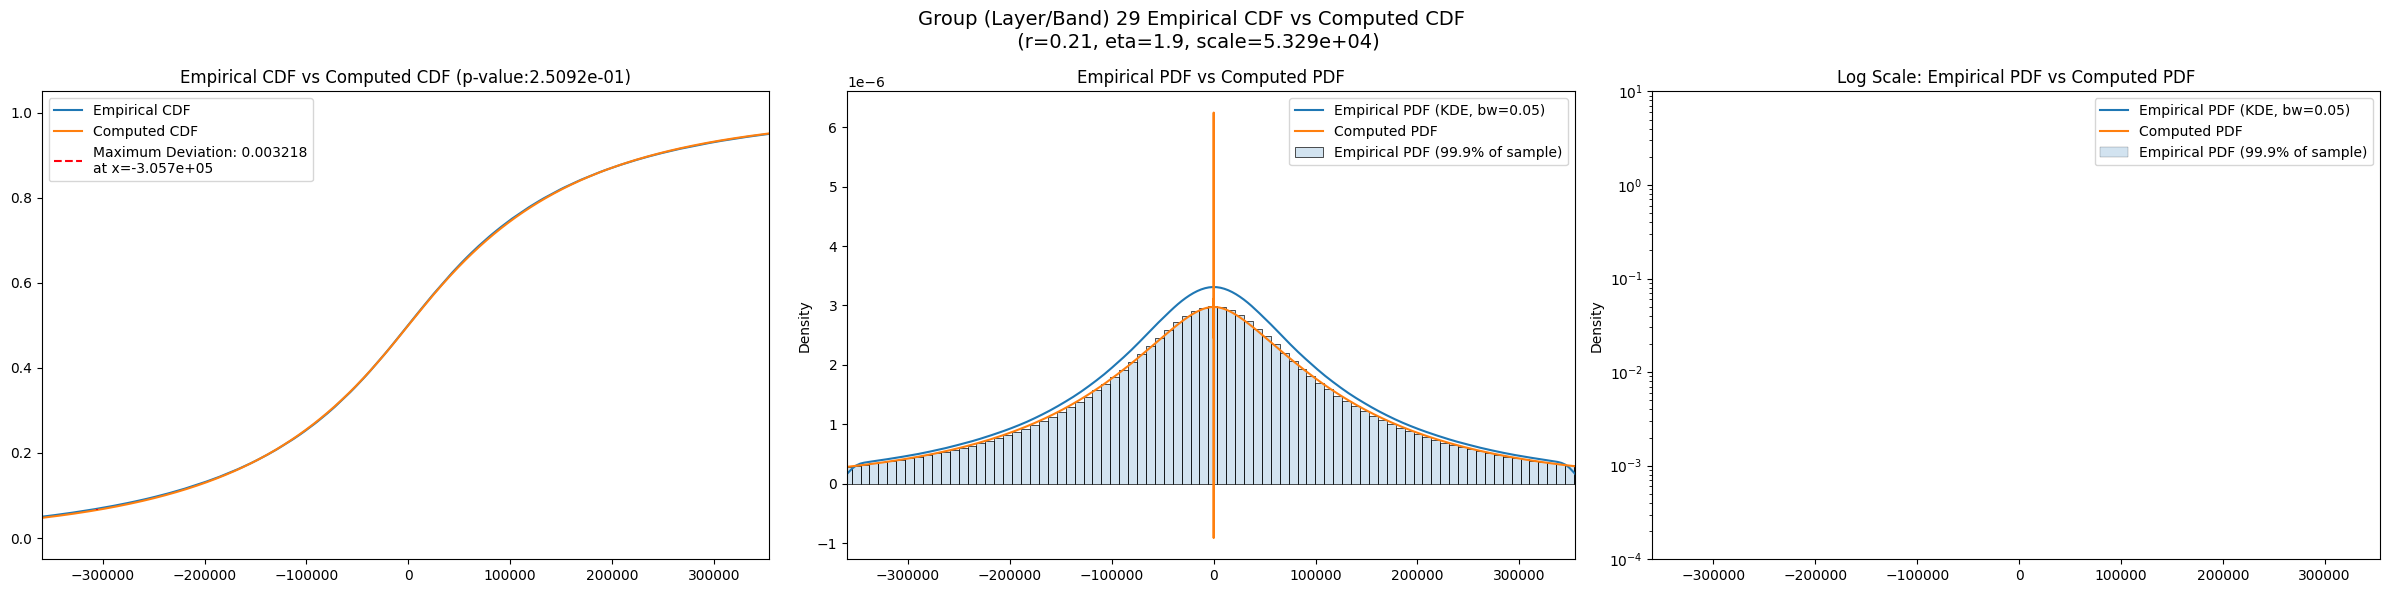

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,3.907990e+14,3.213011e+14,4.705622e+14,5.981112,3.060706,8.597465,1440.0,0.153482,0.1,9.9,...,1000000.0,0.573124,0.000000e+00,1000000.0,0.540617,0.000000e+00,1000000.0,0.518501,0.000000e+00,4.371292e-30
5,8.619868e+14,7.597638e+14,9.705736e+14,20.513369,17.319409,23.942896,14400.0,0.020931,0.1,6.9,...,1000000.0,0.426403,0.000000e+00,1000000.0,0.390310,0.000000e+00,1000000.0,0.366700,0.000000e+00,6.528374e-06
8,1.826341e+14,1.574274e+14,2.108616e+14,30.720031,21.959829,41.223043,27360.0,0.017674,0.1,8.7,...,1000000.0,0.362570,0.000000e+00,1000000.0,0.317503,0.000000e+00,1000000.0,0.293415,0.000000e+00,8.019037e-08
11,1.413384e+13,1.141042e+13,1.895579e+13,105.616169,12.570871,283.376403,56160.0,0.004340,0.2,9.4,...,1000000.0,0.223075,0.000000e+00,1000000.0,0.178222,0.000000e+00,1000000.0,0.153233,0.000000e+00,3.169174e-01
14,3.339637e+14,3.084108e+14,3.620677e+14,7.901885,5.022119,12.454595,100000.0,0.067749,0.1,5.2,...,1000000.0,0.455154,0.000000e+00,1000000.0,0.418362,0.000000e+00,1000000.0,0.394985,0.000000e+00,0.000000e+00
17,4.391542e+14,4.184581e+14,4.612009e+14,1.599081,1.112939,2.882672,100000.0,0.006790,0.1,14.0,...,1000000.0,0.434872,0.000000e+00,1000000.0,0.403994,0.000000e+00,1000000.0,0.381501,0.000000e+00,3.722853e-02
20,1.863235e+13,1.759787e+13,1.997386e+13,3.611286,1.579866,15.278751,100000.0,0.001820,0.2,7.1,...,1000000.0,0.271017,0.000000e+00,1000000.0,0.224441,0.000000e+00,1000000.0,0.200066,0.000000e+00,9.153329e-01
23,5.684017e+12,5.313017e+12,6.385912e+12,9.221800,2.312359,81.392754,100000.0,0.002196,0.2,5.2,...,1000000.0,0.149572,0.000000e+00,1000000.0,0.110694,0.000000e+00,1000000.0,0.084281,0.000000e+00,8.457117e-01
26,2.836541e+11,2.676022e+11,3.008791e+11,3.267833,2.205742,6.772957,100000.0,0.002361,0.2,3.8,...,446256.0,0.023516,1.793170e-48,392578.0,0.008531,9.490320e-07,314258.0,0.012225,2.070010e-13,6.318902e-01


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.153482,0.035671,0.153482,0.573124,0.540617,0.518501
5,0.020931,0.011306,0.020931,0.426403,0.390310,0.366700
8,0.017674,0.008204,0.017636,0.362570,0.317503,0.293415
11,0.004340,0.005728,0.004043,0.223075,0.178222,0.153233
14,0.067749,0.004293,0.067749,0.455154,0.418362,0.394985
17,0.006790,0.004293,0.004461,0.434872,0.403994,0.381501
20,0.001820,0.004293,0.001761,0.271017,0.224441,0.200066
23,0.002196,0.004293,0.001939,0.149572,0.110694,0.084281
26,0.002361,0.004293,0.002361,0.023516,0.008531,0.012225


In [21]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,3.907990e+14,0.153482,0.10,9.9,7.178710e-07,0.0
5,3.243172e+14,0.020931,0.10,6.9,1.106182e-05,200.0
8,7.858027e+13,0.017636,0.09,8.6,8.050428e-10,250.0
11,9.677576e+12,0.004043,0.19,9.3,4.647765e+03,125.0
14,3.210852e+14,0.067749,0.10,5.2,9.269776e-05,50.0
17,4.337970e+14,0.004461,0.12,14.0,8.783064e-04,25.0
20,1.827303e+13,0.001761,0.19,7.4,2.335236e+04,25.0
23,5.526452e+12,0.001939,0.19,5.3,2.718444e+04,25.0
26,2.836541e+11,0.002361,0.20,3.8,1.517902e+04,0.0
